## **Project Title:**

*Integrating Retail Demand Forecasting and Inventory Optimization to Enhance Supply Chain Efficiency*



### Import Required Libraries

In [3]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error


from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Load Dataset

In [4]:
# Drive Mounting

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
# Check  files in folder

datasets_list = os.listdir('/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/m5-forecasting-accuracy')

for files in datasets_list:
  print(files)

sales_train_evaluation.csv
sell_prices.csv
sales_train_validation.csv
calendar.csv
sample_submission.csv


1. sales_train_validation.csv is the main dataset for time-series modelling which contains daily unit sales for each item–store combination.

2. sell_prices.csv contains historical prices for each item–store which is needed to understand price elasticity

3. calendar.csv contains date-level attributes such as events, SNAP, weekdays, month, year which useful for adding event features, capturing seasonality, understanding demand spikes.

4. Skipping sales_train_evaluation.csv and sample_submission.csv because they are competition-specific files not needed for training, validation, or analysis.

In [136]:
# Load my required dateset

path = '/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/m5-forecasting-accuracy'


sales = pd.read_csv(os.path.join(path, 'sales_train_validation.csv'))
calendar = pd.read_csv(os.path.join(path, 'calendar.csv'))
prices = pd.read_csv(os.path.join(path, 'sell_prices.csv'))

print("Sales shape:", sales.shape)
print("Calendar shape:", calendar.shape)
print("Prices shape:", prices.shape)

Sales shape: (30490, 1919)
Calendar shape: (1969, 14)
Prices shape: (6841121, 4)


In [86]:
# Check Sales dataset
sales.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1


In [87]:
# Check DataFrame’s structure
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


It’s a wide dataset with mostly numeric daily sales data and a few categorical identifiers.

In [137]:
# Check Missing Values

missing_data = sales.isnull().sum()
missing_data[missing_data > 0]

,0


In [89]:
# Check unique values in column except day column
for col in sales.columns:
  if not col.startswith('d_'):
    print(f"{col}: {sales[col].nunique()}")


id: 30490
item_id: 3049
dept_id: 7
cat_id: 3
store_id: 10
state_id: 3


In [90]:
# Check statistical Summary
sales.describe()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
count,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,...,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000
mean,1.070220,1.041292,0.780026,0.833454,0.627944,0.958052,0.918662,1.244080,1.073663,0.838701,...,1.370581,1.586159,1.693670,1.248245,1.232207,1.159167,1.149000,1.328862,1.605838,1.633158
std,5.126689,5.365468,3.667454,4.415141,3.379344,4.785947,5.059495,6.617729,5.917204,4.206199,...,3.740017,4.097191,4.359809,3.276925,3.125471,2.876026,2.950364,3.358012,4.089422,3.812248
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000
max,360.000000,436.000000,207.000000,323.000000,296.000000,314.000000,316.000000,370.000000,385.000000,353.000000,...,129.000000,160.000000,204.000000,98.000000,100.000000,88.000000,77.000000,141.000000,171.000000,130.000000


In [138]:
# Check for duplicates

print(sales.duplicated().sum())

0


In [92]:
# Check count the frequency of unique values of state_ID

sales['state_id'].value_counts()

,count
state_id,
CA,12196
TX,9147
WI,9147


In [93]:
# Check count the frequency of unique values of store_id

sales['store_id'].value_counts()

,count
store_id,
CA_1,3049
CA_2,3049
CA_3,3049
CA_4,3049
TX_1,3049
TX_2,3049
TX_3,3049
WI_1,3049
WI_2,3049


In [94]:
# Check count the frequency of unique values of cat_id

sales['cat_id'].value_counts()

,count
cat_id,
FOODS,14370
HOUSEHOLD,10470
HOBBIES,5650


In [95]:
# Check count the frequency of unique values of dept_id

sales['dept_id'].value_counts()

,count
dept_id,
FOODS_3,8230
HOUSEHOLD_1,5320
HOUSEHOLD_2,5150
HOBBIES_1,4160
FOODS_2,3980
FOODS_1,2160
HOBBIES_2,1490


In [96]:
# Check unique values

print(sales['state_id'].unique())
print(sales['store_id'].unique())
print(sales['cat_id'].unique())

['CA' 'TX' 'WI']
['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']
['HOBBIES' 'HOUSEHOLD' 'FOODS']


## Creating subset for demonstration

In [97]:
# Creating dataset with product selling minimum 20 per day(considering day 1)

sales_filtered = sales[sales['d_1']> 10]

In [98]:
print(sales_filtered['state_id'].value_counts(),'\n')

print(sales_filtered['store_id'].value_counts(),'\n')

print(sales_filtered['cat_id'].value_counts(),'\n')

print(sales_filtered['dept_id'].value_counts(),'\n')

state_id
CA    268
WI    172
TX    145
Name: count, dtype: int64 

store_id
CA_3    91
CA_1    84
CA_2    82
WI_3    77
TX_2    67
WI_1    54
WI_2    41
TX_1    39
TX_3    39
CA_4    11
Name: count, dtype: int64 

cat_id
FOODS        449
HOBBIES       69
HOUSEHOLD     67
Name: count, dtype: int64 

dept_id
FOODS_3        349
FOODS_2         70
HOBBIES_1       69
HOUSEHOLD_1     65
FOODS_1         30
HOUSEHOLD_2      2
Name: count, dtype: int64 



In [139]:
# Creating subset by filtering to state, store, category

sales_subset = sales_filtered[(sales_filtered["state_id"] == "WI") & (sales_filtered["store_id"] == "WI_3") & (sales_filtered["cat_id"] == "FOODS") & (sales_filtered["dept_id"] == "FOODS_2")]
sales_subset.head(50)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
29289,FOODS_2_021_WI_3_validation,FOODS_2_021,FOODS_2,FOODS,WI_3,WI,29,24,12,40,...,0,0,2,0,0,0,1,0,0,0
29395,FOODS_2_128_WI_3_validation,FOODS_2_128,FOODS_2,FOODS,WI_3,WI,13,8,19,8,...,7,4,5,5,3,8,2,2,5,3
29419,FOODS_2_152_WI_3_validation,FOODS_2_152,FOODS_2,FOODS,WI_3,WI,12,10,9,6,...,4,2,6,4,4,1,3,7,1,5
29431,FOODS_2_164_WI_3_validation,FOODS_2_164,FOODS_2,FOODS,WI_3,WI,12,10,12,7,...,6,15,4,0,2,0,2,9,3,2
29448,FOODS_2_181_WI_3_validation,FOODS_2_181,FOODS_2,FOODS,WI_3,WI,15,26,23,19,...,13,17,26,10,10,5,9,11,8,4
29500,FOODS_2_233_WI_3_validation,FOODS_2_233,FOODS_2,FOODS,WI_3,WI,12,6,4,8,...,6,7,5,3,1,6,8,5,3,4
29543,FOODS_2_276_WI_3_validation,FOODS_2_276,FOODS_2,FOODS,WI_3,WI,22,25,20,13,...,2,9,3,10,6,4,7,4,7,9
29627,FOODS_2_360_WI_3_validation,FOODS_2_360,FOODS_2,FOODS,WI_3,WI,26,22,18,3,...,27,16,11,12,6,19,25,17,14,6
29631,FOODS_2_364_WI_3_validation,FOODS_2_364,FOODS_2,FOODS,WI_3,WI,28,34,38,59,...,5,6,7,1,5,1,3,4,2,5
29665,FOODS_2_398_WI_3_validation,FOODS_2_398,FOODS_2,FOODS,WI_3,WI,11,15,12,14,...,8,16,7,5,3,18,5,9,3,4


In [140]:
sales_subset.shape

(10, 1919)

In [101]:
# Re-Check unique values in column except day column
for col in sales_subset.columns:
  if not col.startswith('d_'):
    print(f"{col}: {sales_subset[col].nunique()}")

id: 10
item_id: 10
dept_id: 1
cat_id: 1
store_id: 1
state_id: 1


## Transforming Sales Data: Wide to Long Format

In [141]:
# Melt the sales data from wide (d_1, d_2…) to long format

id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
sales_long = pd.melt(sales_subset,id_vars=id_vars,var_name="d",value_name="sales")
sales_long.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,FOODS_2_021_WI_3_validation,FOODS_2_021,FOODS_2,FOODS,WI_3,WI,d_1,29
1,FOODS_2_128_WI_3_validation,FOODS_2_128,FOODS_2,FOODS,WI_3,WI,d_1,13
2,FOODS_2_152_WI_3_validation,FOODS_2_152,FOODS_2,FOODS,WI_3,WI,d_1,12


In [142]:
# Check data structure
sales_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19130 entries, 0 to 19129
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        19130 non-null  object
 1   item_id   19130 non-null  object
 2   dept_id   19130 non-null  object
 3   cat_id    19130 non-null  object
 4   store_id  19130 non-null  object
 5   state_id  19130 non-null  object
 6   d         19130 non-null  object
 7   sales     19130 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 1.2+ MB


In [143]:
# Convert the "d" column (like "d_1", "d_2") into a numeric day index

sales_long["day_number"] = sales_long["d"].str.extract(r"_(\d+)").astype(int)
sales_long.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,day_number
0,FOODS_2_021_WI_3_validation,FOODS_2_021,FOODS_2,FOODS,WI_3,WI,d_1,29,1
1,FOODS_2_128_WI_3_validation,FOODS_2_128,FOODS_2,FOODS,WI_3,WI,d_1,13,1
2,FOODS_2_152_WI_3_validation,FOODS_2_152,FOODS_2,FOODS,WI_3,WI,d_1,12,1


Note: The \d+ in the regular expression means “match one or more digits”.

\d → matches any single digit (0–9)

'+' → means “one or more times”

So \d+ will match numbers like 1, 12, 1913, etc.

In [105]:
# Check calendar dataset
calendar.head(3)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0


In [144]:
# Merge with calendar by "d" column that matches the "d" in sales_long
sales_long = sales_long.merge(calendar, how="left", on="d")
sales_long.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,day_number,date,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,FOODS_2_021_WI_3_validation,FOODS_2_021,FOODS_2,FOODS,WI_3,WI,d_1,29,1,2011-01-29,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,FOODS_2_128_WI_3_validation,FOODS_2_128,FOODS_2,FOODS,WI_3,WI,d_1,13,1,2011-01-29,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,FOODS_2_152_WI_3_validation,FOODS_2_152,FOODS_2,FOODS,WI_3,WI,d_1,12,1,2011-01-29,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0


In [107]:
# Check prices dataset
prices.head(3)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26


## Check if calender & Prices can be merge by wm_yr_wk

In [108]:
# Filtered calender by wm_yr_wk value 11101 (random  choice)
calendar[calendar['wm_yr_wk']==11101].head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [109]:
# Filtered prices by wm_yr_wk value 11101 (random  choice)

prices[prices['wm_yr_wk']==11101].head()

,store_id,item_id,wm_yr_wk,sell_price
1512,CA_1,HOBBIES_1_008,11101,0.46
1794,CA_1,HOBBIES_1_009,11101,1.56
2076,CA_1,HOBBIES_1_010,11101,3.17
2576,CA_1,HOBBIES_1_012,11101,5.98
3318,CA_1,HOBBIES_1_015,11101,0.70


In [145]:
# Merge with prices by wm_yr_wk

sales_long = sales_long.merge(prices,on=["store_id", "item_id", "wm_yr_wk"],how="left")
sales_long.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,day_number,date,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,FOODS_2_021_WI_3_validation,FOODS_2_021,FOODS_2,FOODS,WI_3,WI,d_1,29,1,2011-01-29,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.64
1,FOODS_2_128_WI_3_validation,FOODS_2_128,FOODS_2,FOODS,WI_3,WI,d_1,13,1,2011-01-29,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.64
2,FOODS_2_152_WI_3_validation,FOODS_2_152,FOODS_2,FOODS,WI_3,WI,d_1,12,1,2011-01-29,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,1.98


If I merged only on wm_yr_wk, I could get:

Prices from a different item in the same week or

Prices from a different store in the same week

So , I used "store_id", "item_id", "wm_yr_wk"

In [111]:
# Check final columns  name
sales_long.keys()

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'day_number', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month',
       'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'],
      dtype='object')

## Basic overview with Final Dataset

In [129]:
# Data structure of final dataset
sales_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19130 entries, 0 to 19129
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            19130 non-null  object        
 1   item_id       19130 non-null  object        
 2   dept_id       19130 non-null  object        
 3   cat_id        19130 non-null  object        
 4   store_id      19130 non-null  object        
 5   state_id      19130 non-null  object        
 6   d             19130 non-null  object        
 7   sales         19130 non-null  int64         
 8   day_number    19130 non-null  int64         
 9   date          19130 non-null  datetime64[ns]
 10  wm_yr_wk      19130 non-null  int64         
 11  weekday       19130 non-null  object        
 12  wday          19130 non-null  int64         
 13  month         19130 non-null  int64         
 14  year          19130 non-null  int64         
 15  event_name_1  19130 non-null  object

In [130]:
sales_long.describe()

,sales,day_number,date,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI,sell_price
count,19130.000000,19130.000000,19130,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000
mean,7.062520,957.000000,2013-09-10 23:59:59.999999744,11339.191323,3.997386,6.357554,2013.209096,0.329326,0.329326,0.329326,2.254731
min,0.000000,1.000000,2011-01-29 00:00:00,11101.000000,1.000000,1.000000,2011.000000,0.000000,0.000000,0.000000,0.640000
25%,0.000000,479.000000,2012-05-21 00:00:00,11217.000000,2.000000,3.000000,2012.000000,0.000000,0.000000,0.000000,0.940000
50%,4.000000,957.000000,2013-09-11 00:00:00,11333.000000,4.000000,6.000000,2013.000000,0.000000,0.000000,0.000000,2.420000
75%,10.000000,1435.000000,2015-01-02 00:00:00,11448.000000,6.000000,9.000000,2015.000000,1.000000,1.000000,1.000000,2.980000
max,83.000000,1913.000000,2016-04-24 00:00:00,11613.000000,7.000000,12.000000,2016.000000,1.000000,1.000000,1.000000,4.480000
std,9.594391,552.249891,NaN,150.378111,2.000704,3.458864,1.532126,0.469981,0.469981,0.469981,1.122140


In [116]:
# Check shape of our final dataset

sales_long.shape

(19130, 23)

In [146]:
# Missing values summary

missing_summary = sales_long.isnull().sum()
missing_summary[missing_summary > 0]

,0
event_name_1,17590
event_type_1,17590
event_name_2,19090
event_type_2,19090


In [147]:
# Fill missing events with "No Event" and type with "None"

sales_long['event_name_1'].fillna('No Event', inplace=True)
sales_long['event_type_1'].fillna('None', inplace=True)
sales_long['event_name_2'].fillna('No Event', inplace=True)
sales_long['event_type_2'].fillna('None', inplace=True)

In [148]:
# Recheck Missing values summary

missing_summary = sales_long.isnull().sum()
missing_summary[missing_summary > 0]

,0


In [149]:
# Check any duplicated values

sales_long.duplicated().sum()

np.int64(0)

In [150]:
# Save final dataset

sales_long.to_csv('sales_merge_dataset.csv', index=False)

## Load saved final dataset ( Store : WI_3, Dept : FOODS_2)

In [228]:
Sales_df = pd.read_csv('sales_merge_dataset.csv')

## Basic overview

In [ ]:
# Show all columns

pd.set_option('display.max_columns', None)

In [229]:
Sales_df.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,day_number,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,FOODS_2_021_WI_3_validation,FOODS_2_021,FOODS_2,FOODS,WI_3,WI,d_1,29,1,2011-01-29,11101,Saturday,1,1,2011,No Event,NaN,No Event,NaN,0,0,0,0.64
1,FOODS_2_128_WI_3_validation,FOODS_2_128,FOODS_2,FOODS,WI_3,WI,d_1,13,1,2011-01-29,11101,Saturday,1,1,2011,No Event,NaN,No Event,NaN,0,0,0,0.64
2,FOODS_2_152_WI_3_validation,FOODS_2_152,FOODS_2,FOODS,WI_3,WI,d_1,12,1,2011-01-29,11101,Saturday,1,1,2011,No Event,NaN,No Event,NaN,0,0,0,1.98


In [230]:
Sales_df.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,day_number,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
19125,FOODS_2_233_WI_3_validation,FOODS_2_233,FOODS_2,FOODS,WI_3,WI,d_1913,4,1913,2016-04-24,11613,Sunday,2,4,2016,No Event,NaN,No Event,NaN,0,0,0,4.48
19126,FOODS_2_276_WI_3_validation,FOODS_2_276,FOODS_2,FOODS,WI_3,WI,d_1913,9,1913,2016-04-24,11613,Sunday,2,4,2016,No Event,NaN,No Event,NaN,0,0,0,3.42
19127,FOODS_2_360_WI_3_validation,FOODS_2_360,FOODS_2,FOODS,WI_3,WI,d_1913,6,1913,2016-04-24,11613,Sunday,2,4,2016,No Event,NaN,No Event,NaN,0,0,0,0.94
19128,FOODS_2_364_WI_3_validation,FOODS_2_364,FOODS_2,FOODS,WI_3,WI,d_1913,5,1913,2016-04-24,11613,Sunday,2,4,2016,No Event,NaN,No Event,NaN,0,0,0,2.74
19129,FOODS_2_398_WI_3_validation,FOODS_2_398,FOODS_2,FOODS,WI_3,WI,d_1913,4,1913,2016-04-24,11613,Sunday,2,4,2016,No Event,NaN,No Event,NaN,0,0,0,2.43


In [231]:
Sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19130 entries, 0 to 19129
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            19130 non-null  object 
 1   item_id       19130 non-null  object 
 2   dept_id       19130 non-null  object 
 3   cat_id        19130 non-null  object 
 4   store_id      19130 non-null  object 
 5   state_id      19130 non-null  object 
 6   d             19130 non-null  object 
 7   sales         19130 non-null  int64  
 8   day_number    19130 non-null  int64  
 9   date          19130 non-null  object 
 10  wm_yr_wk      19130 non-null  int64  
 11  weekday       19130 non-null  object 
 12  wday          19130 non-null  int64  
 13  month         19130 non-null  int64  
 14  year          19130 non-null  int64  
 15  event_name_1  19130 non-null  object 
 16  event_type_1  1540 non-null   object 
 17  event_name_2  19130 non-null  object 
 18  event_type_2  40 non-null 

In [232]:
Sales_df.describe()

,sales,day_number,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI,sell_price
count,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000
mean,7.062520,957.000000,11339.191323,3.997386,6.357554,2013.209096,0.329326,0.329326,0.329326,2.254731
std,9.594391,552.249891,150.378111,2.000704,3.458864,1.532126,0.469981,0.469981,0.469981,1.122140
min,0.000000,1.000000,11101.000000,1.000000,1.000000,2011.000000,0.000000,0.000000,0.000000,0.640000
25%,0.000000,479.000000,11217.000000,2.000000,3.000000,2012.000000,0.000000,0.000000,0.000000,0.940000
50%,4.000000,957.000000,11333.000000,4.000000,6.000000,2013.000000,0.000000,0.000000,0.000000,2.420000
75%,10.000000,1435.000000,11448.000000,6.000000,9.000000,2015.000000,1.000000,1.000000,1.000000,2.980000
max,83.000000,1913.000000,11613.000000,7.000000,12.000000,2016.000000,1.000000,1.000000,1.000000,4.480000


What to write in dissertation

Dataset contains transactional daily sales at item–store level

No missing values in target (sales)

Calendar, price, SNAP, and event variables enrich demand signals

# Exploratory Data Analysis (EDA)

I will check sales patterns and price/promotion effects which are critical for demand forecasting and inventory optimization

## Target Variable Analysis (Sales)

### Sales distribution

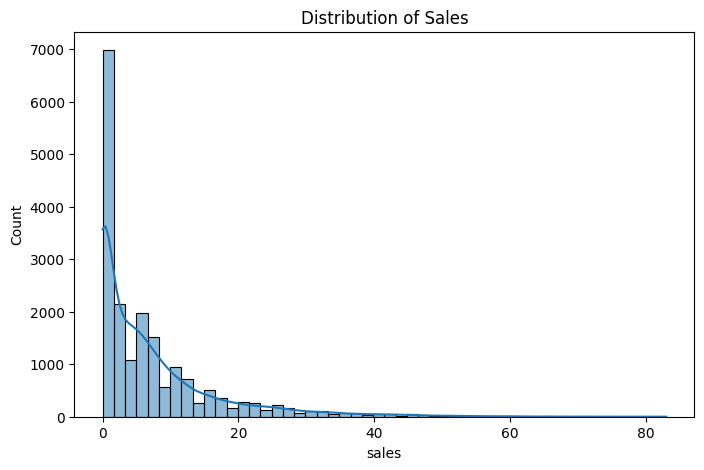

In [233]:
# Distribution of sales
plt.figure(figsize=(8,5))
sns.histplot(Sales_df['sales'], bins=50, kde=True)
plt.title("Distribution of Sales")
plt.savefig("distribution_of_sales.png")
plt.show()

### Zero-sales proportion (important for inventory risk)

In [234]:
zero_ratio = (Sales_df['sales'] == 0).mean() * 100
print(f"Zero-sales days: {zero_ratio:.2f}%")


Zero-sales days: 31.90%


### Outlier detection

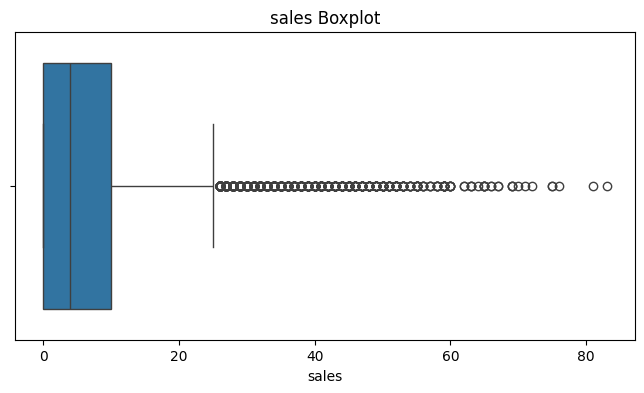

In [235]:
plt.figure(figsize=(8,4))
sns.boxplot(x='sales', data=Sales_df)
plt.title('sales Boxplot')
plt.show()

Dissertation insight

Retail demand is sparse and intermittent

High zero-sales frequency motivates safety stock modelling

## Time Series Behaviour (Trend & Seasonality)

Purpose: justify time-series and deep learning models.

### Convert date

In [236]:
# Convert 'date' to datetime
Sales_df['date'] = pd.to_datetime(Sales_df['date'])

### Aggregate overall sales trend

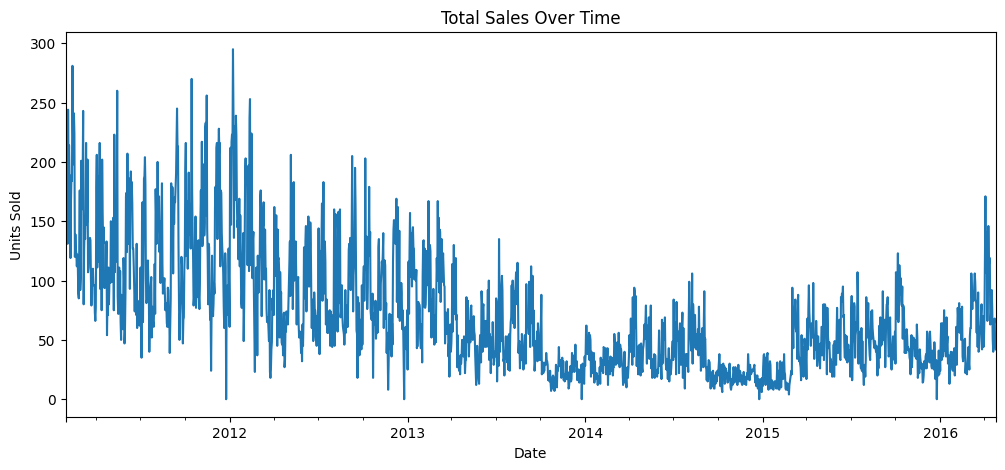

In [237]:
# Aggregate sales by date and sort
daily_sales = Sales_df.groupby('date')['sales'].sum().sort_index()

# Plot
plt.figure(figsize=(12,5))
daily_sales.plot()
plt.title("Total Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.savefig("total_sales_over_time.png")
plt.show()


In [238]:
daily_sales.head()

,sales
date,
2011-01-29,180
2011-01-30,180
2011-01-31,167
2011-02-01,177
2011-02-02,131


### Rolling mean (trend smoothing)

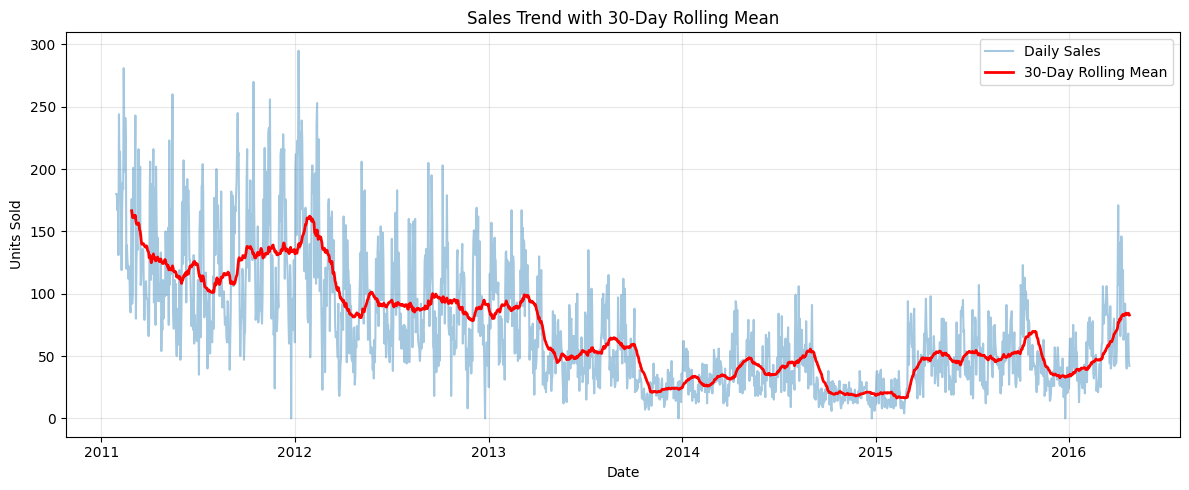

In [239]:
rolling_30 = daily_sales.rolling(30).mean()

plt.figure(figsize=(12,5))
plt.plot(daily_sales.index, daily_sales.values, alpha=0.4,label='Daily Sales')
plt.plot(rolling_30.index, rolling_30.values,linewidth=2, color='red',label='30-Day Rolling Mean')
plt.title('Sales Trend with 30-Day Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("sales_trend_with_rolling_mean.png")
plt.tight_layout()
plt.show()


Dissertation insight

Clear temporal dependency → forecasting models are appropriate

Rolling trend informs reorder frequency

## Weekly & Yearly Seasonality

Purpose: justify seasonal parameters (e.g. 7-day seasonality).

In [173]:
Sales_df.keys()

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'day_number', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month',
       'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'],
      dtype='object')

### Weekly pattern

In [192]:
# Checking if weekday & number in same order

Weekday = {}
Weekday_number = {}

for i in Sales_df['wday'].unique():
  Weekday = Sales_df[Sales_df['wday']==i]['weekday'].unique()
  Weekday_number = i
  print(f"Weekday {Weekday_number}: {Weekday}")

Weekday 1: ['Saturday']
Weekday 2: ['Sunday']
Weekday 3: ['Monday']
Weekday 4: ['Tuesday']
Weekday 5: ['Wednesday']
Weekday 6: ['Thursday']
Weekday 7: ['Friday']


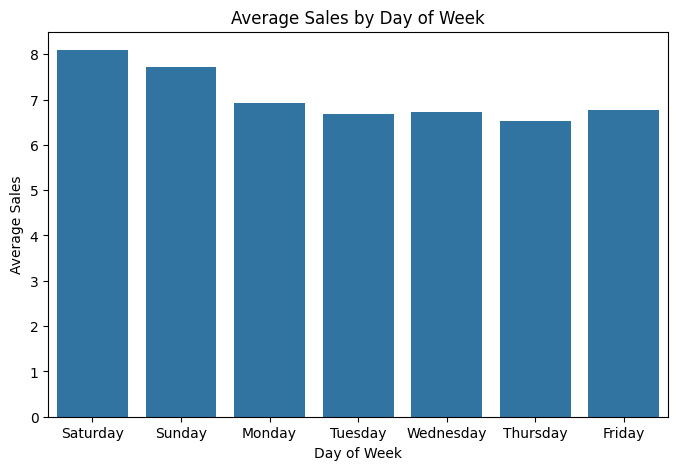

In [276]:
weekly_pattern = Sales_df.groupby('weekday')['sales'].mean().reindex(Sales_df['weekday']).reset_index()

plt.figure(figsize=(8,5))
sns.barplot(x='weekday', y='sales', data=weekly_pattern)
plt.title('Average Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.show()


### Monthly pattern

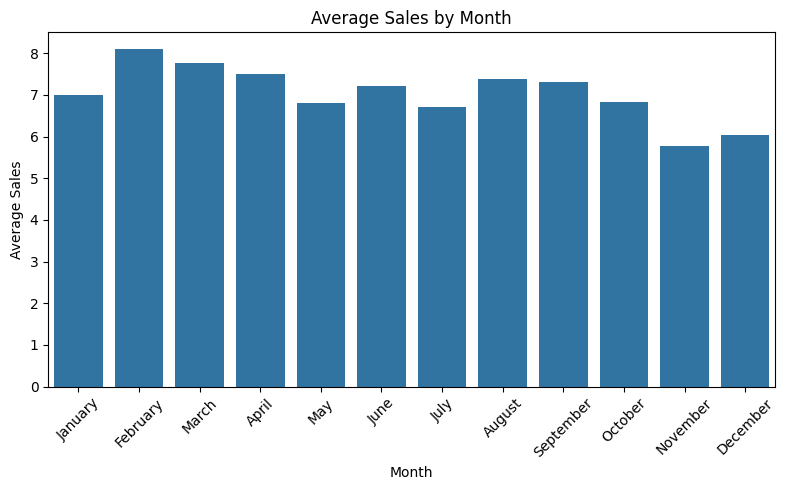

In [241]:
Sales_df['month_name'] = Sales_df['date'].dt.month_name()

monthly_pattern = Sales_df.groupby('month_name')['sales'].mean().reindex(Sales_df['month_name']).reset_index()

plt.figure(figsize=(8,5))
sns.barplot(x='month_name', y='sales', data=monthly_pattern)
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Dissertation insight

Strong weekly seasonality supports SARIMA and Holt-Winters

Month effects justify calendar features in ML models

## Item level sales Behaviour

Purpose: show demand heterogeneity (important for inventory policy).

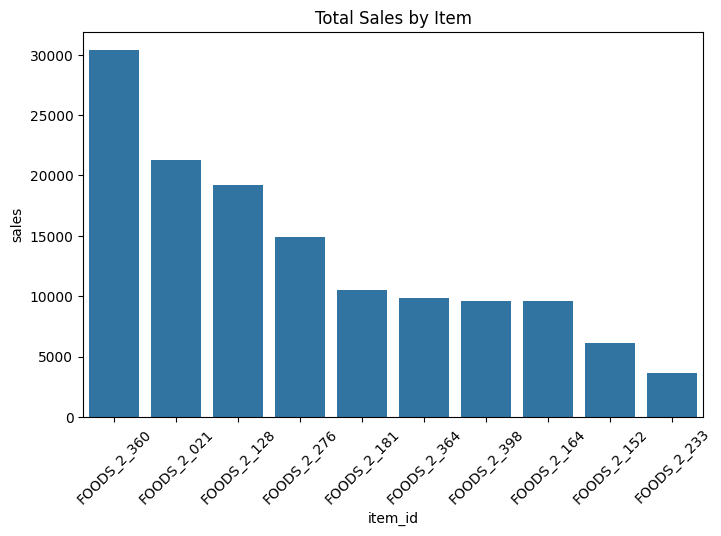

In [244]:
store_sales = Sales_df.groupby('item_id')['sales'].sum().reset_index()

# Sort in descending order before plotting
store_sales = store_sales.sort_values(by='sales', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='item_id', y='sales', data=store_sales)
plt.title('Total Sales by Item')
plt.xticks(rotation=45)
plt.show()

## Price Effect Analysis
Purpose: connect demand forecasting with cost-based inventory decisions.

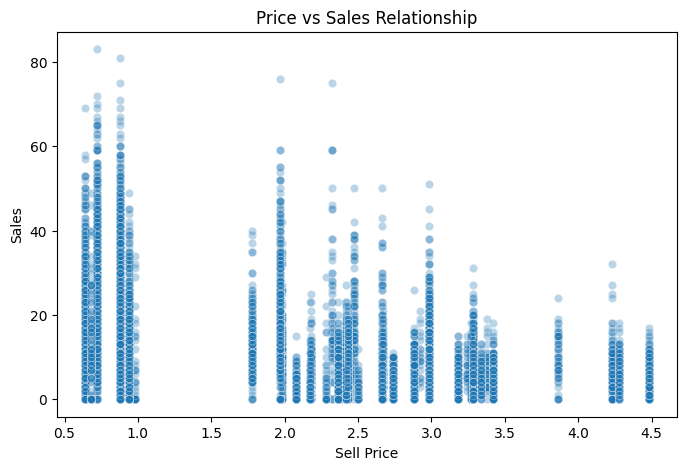

In [245]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='sell_price', y='sales', data=Sales_df, alpha=0.3)
plt.title('Price vs Sales Relationship')
plt.xlabel('Sell Price')
plt.ylabel('Sales')
plt.show()


In [246]:
price_corr = Sales_df[['sales','sell_price']].corr()
price_corr


,sales,sell_price
sales,1.000000,-0.353022
sell_price,-0.353022,1.000000


Dissertation insight

Price sensitivity affects order quantity decisions

Useful for avoiding overstock on high-price items

## Promotion & Event Impact
Purpose: justify exogenous variables.

### SNAP effect

In [248]:
Sales_df.keys()

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'day_number', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month',
       'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'month_name'],
      dtype='object')

In [272]:
Sales_df['snap_WI'].unique()

array([0, 1])

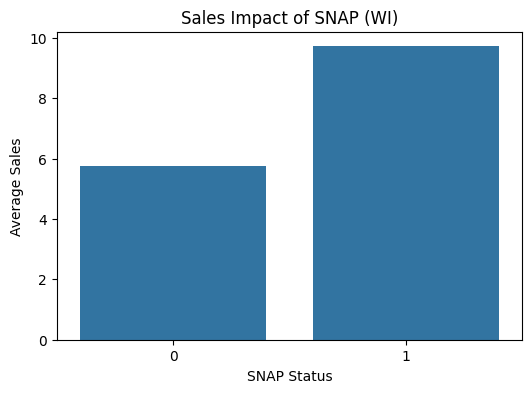

In [273]:
snap_effect = Sales_df.groupby('snap_WI')['sales'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(x='snap_WI', y='sales', data=snap_effect)
plt.title('Sales Impact of SNAP (WI)')
plt.xlabel('SNAP Status')
plt.ylabel('Average Sales')
plt.show()


In [262]:
Sales_df['event_type_1'].unique()

array([nan, 'Sporting', 'Cultural', 'National', 'Religious'], dtype=object)

In [263]:
Sales_df['event_name_1'].unique()

array(['No Event', 'SuperBowl', 'ValentinesDay', 'PresidentsDay',
       'LentStart', 'LentWeek2', 'StPatricksDay', 'Purim End',
       'OrthodoxEaster', 'Pesach End', 'Cinco De Mayo', "Mother's day",
       'MemorialDay', 'NBAFinalsStart', 'NBAFinalsEnd', "Father's day",
       'IndependenceDay', 'Ramadan starts', 'Eid al-Fitr', 'LaborDay',
       'ColumbusDay', 'Halloween', 'EidAlAdha', 'VeteransDay',
       'Thanksgiving', 'Christmas', 'Chanukah End', 'NewYear',
       'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter'], dtype=object)

In [270]:
Sales_df['event_type_2'].unique()

array([nan, 'Cultural', 'Religious'], dtype=object)

In [269]:
Sales_df['event_name_2'].unique()

array(['No Event', 'Easter', 'Cinco De Mayo', 'OrthodoxEaster',
       "Father's day"], dtype=object)

### Events Effect

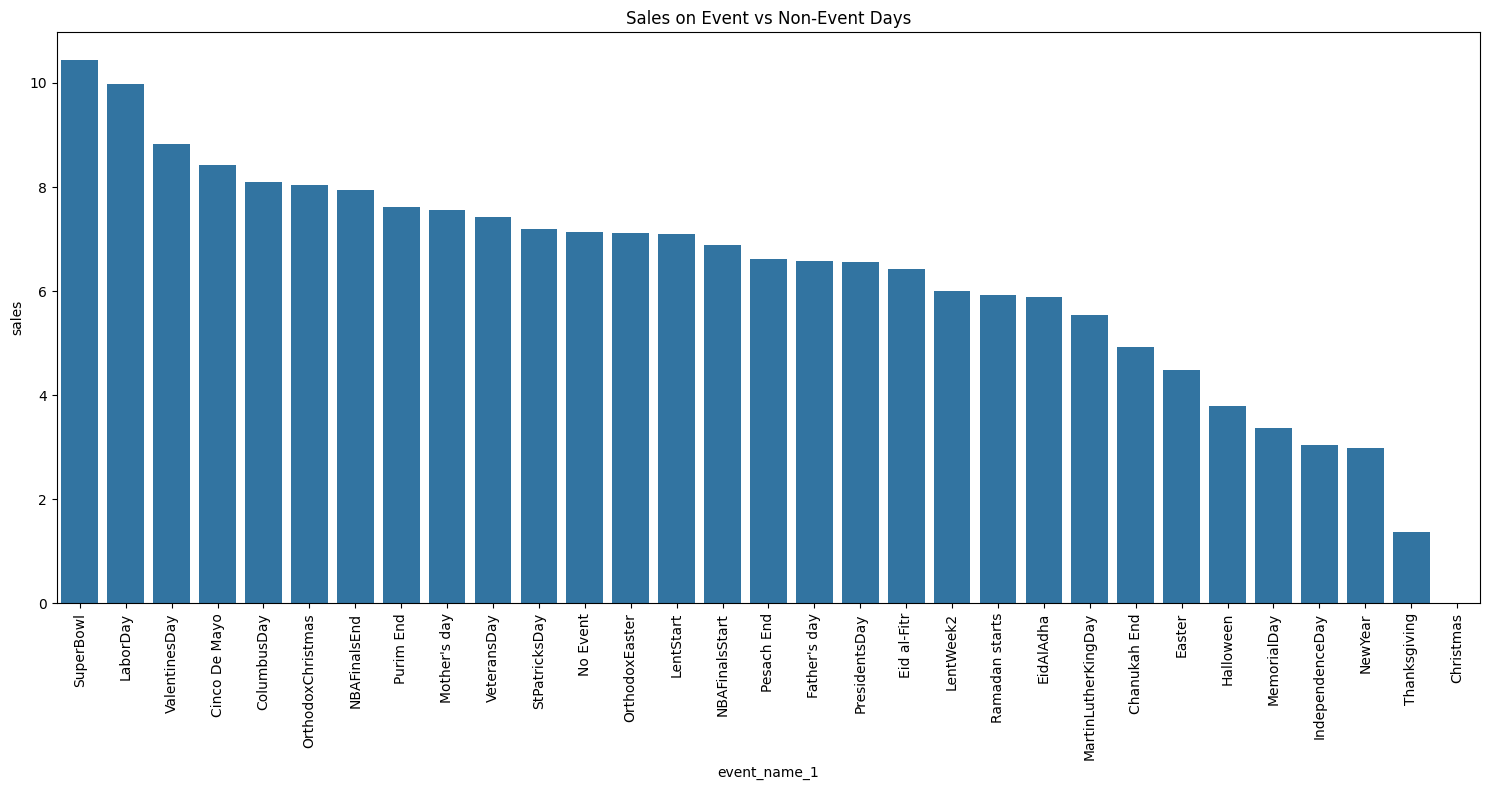

In [267]:
event_sales = Sales_df.groupby('event_name_1')['sales'].mean().reset_index()

event_sales = event_sales.sort_values(by='sales', ascending=False)

plt.figure(figsize=(15,8))
sns.barplot(x='event_name_1', y='sales', data=event_sales)
plt.title('Sales on Event vs Non-Event Days')
#plt.xticks([0,1], ['No Event','Event'])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


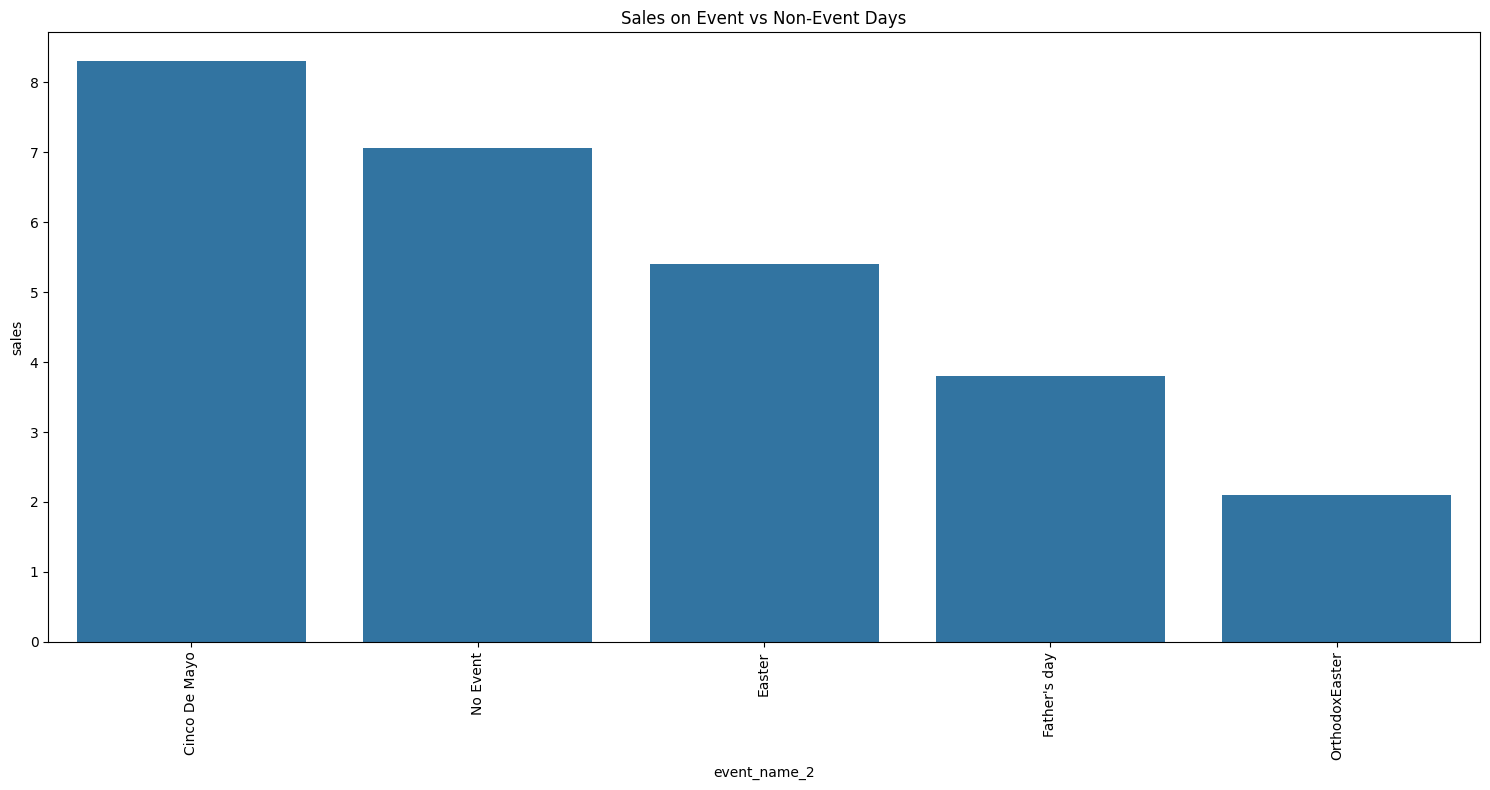

In [268]:
event_sales = Sales_df.groupby('event_name_2')['sales'].mean().reset_index()

event_sales = event_sales.sort_values(by='sales', ascending=False)

plt.figure(figsize=(15,8))
sns.barplot(x='event_name_2', y='sales', data=event_sales)
plt.title('Sales on Event vs Non-Event Days')
#plt.xticks([0,1], ['No Event','Event'])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Dissertation insight

Promotions and events significantly influence demand

Ignoring them leads to poor inventory planning

##Correlation Analysis (Numerical Features)

Purpose: feature selection justification.

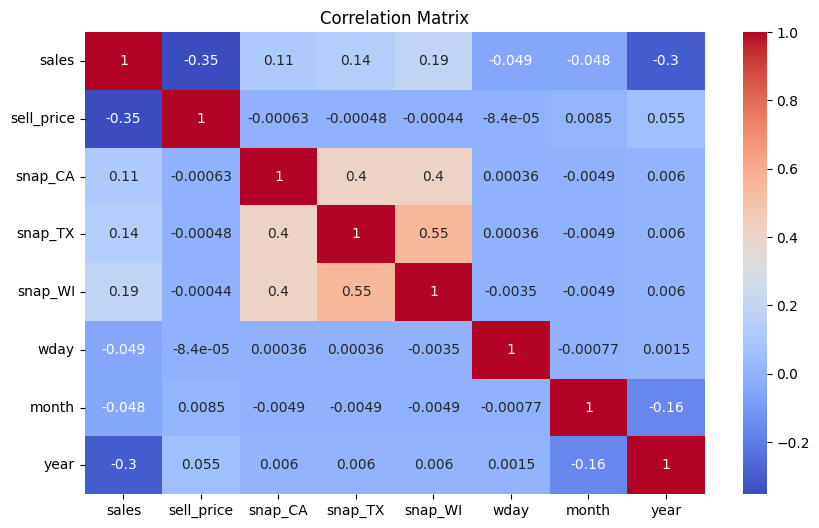

In [227]:
num_cols = [
    'sales','sell_price','snap_CA','snap_TX','snap_WI',
    'wday','month','year'
]

plt.figure(figsize=(10,6))
sns.heatmap(sales_long[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


# **Correct  upto EDA**

## Log Transformation to convert to normal data

In [45]:
sales_long['sales'] = np.log1p(sales_long['sales'])

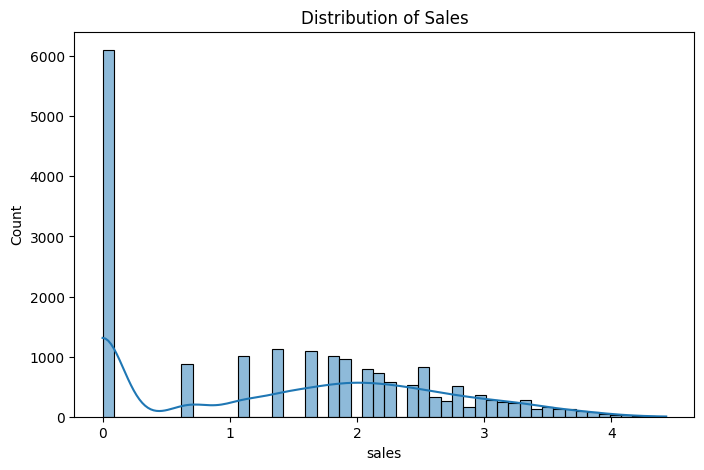

In [46]:
# Check distribution after transformation
plt.figure(figsize=(8,5))
sns.histplot(sales_long['sales'], bins=50, kde=True)
plt.title("Distribution of Sales")
plt.savefig("distribution_of_sales.png")
plt.show()

## Price Features

In [53]:
sales_long['price'] = sales_long['sell_price']

# Price change from previous week
sales_long = sales_long.sort_values(['item_id','store_id','date'])
sales_long['price_change_from_last_week'] = sales_long.groupby(['item_id','store_id'])['price'].diff(7)

# 7-day rolling mean price
sales_long['rolling_mean_price_7d'] = sales_long.groupby(['item_id','store_id'])['price'].transform(lambda x: x.rolling(7, min_periods=1).mean())

## Demand / Sales Features

In [54]:
# Lag features (A lag feature is a value from a previous time step used as a predictor for the current time step.)
sales_long['lag_7'] = sales_long.groupby(['item_id','store_id'])['sales'].shift(7)
sales_long['lag_28'] = sales_long.groupby(['item_id','store_id'])['sales'].shift(28)

# Rolling mean / std (A rolling mean computes the average of a window of consecutive past values.)
sales_long['rolling_mean_7d'] = sales_long.groupby(['item_id','store_id'])['sales'].transform(lambda x: x.shift(1).rolling(7, min_periods=1).mean())
sales_long['rolling_mean_28d'] = sales_long.groupby(['item_id','store_id'])['sales'].transform(lambda x: x.shift(1).rolling(28, min_periods=1).mean())
sales_long['rolling_std_7d'] = sales_long.groupby(['item_id','store_id'])['sales'].transform(lambda x: x.shift(1).rolling(7, min_periods=1).std())

#  Fill NaN for initial periods

sales_long.fillna(0, inplace=True)


## Check new features

In [55]:
sales_long[['date','item_id','store_id','sales','lag_7','lag_28','rolling_mean_7d','rolling_mean_28d','rolling_std_7d','price','price_change_from_last_week','rolling_mean_price_7d','day_of_week','week_of_year','month','year','is_weekend','has_event']].head()


,date,item_id,store_id,sales,lag_7,lag_28,rolling_mean_7d,rolling_mean_28d,rolling_std_7d,price,price_change_from_last_week,rolling_mean_price_7d,day_of_week,week_of_year,month,year,is_weekend,has_event
0,2011-01-29,FOODS_2_021,WI_3,3.401197,0.0,0.0,0.000000,0.000000,0.000000,0.64,0.0,0.64,5,4,1,2011,1,0
10,2011-01-30,FOODS_2_021,WI_3,3.218876,0.0,0.0,3.401197,3.401197,0.000000,0.64,0.0,0.64,6,4,1,2011,1,0
20,2011-01-31,FOODS_2_021,WI_3,2.564949,0.0,0.0,3.310037,3.310037,0.128921,0.64,0.0,0.64,0,5,1,2011,0,0
30,2011-02-01,FOODS_2_021,WI_3,3.713572,0.0,0.0,3.061674,3.061674,0.439729,0.64,0.0,0.64,1,5,2,2011,0,0
40,2011-02-02,FOODS_2_021,WI_3,1.098612,0.0,0.0,3.224649,3.224649,0.484923,0.64,0.0,0.64,2,5,2,2011,0,0


Correlation with target (sales):
sales                          1.000000
rolling_mean_7d                0.827381
rolling_mean_28d               0.792250
lag_7                          0.690298
lag_28                         0.612033
rolling_std_7d                 0.415850
is_weekend                     0.045172
day_of_week                    0.035849
price_change_from_last_week    0.009251
has_event                     -0.032593
month                         -0.051647
week_of_year                  -0.062282
price                         -0.272500
rolling_mean_price_7d         -0.272539
year                          -0.273256
Name: sales, dtype: float64


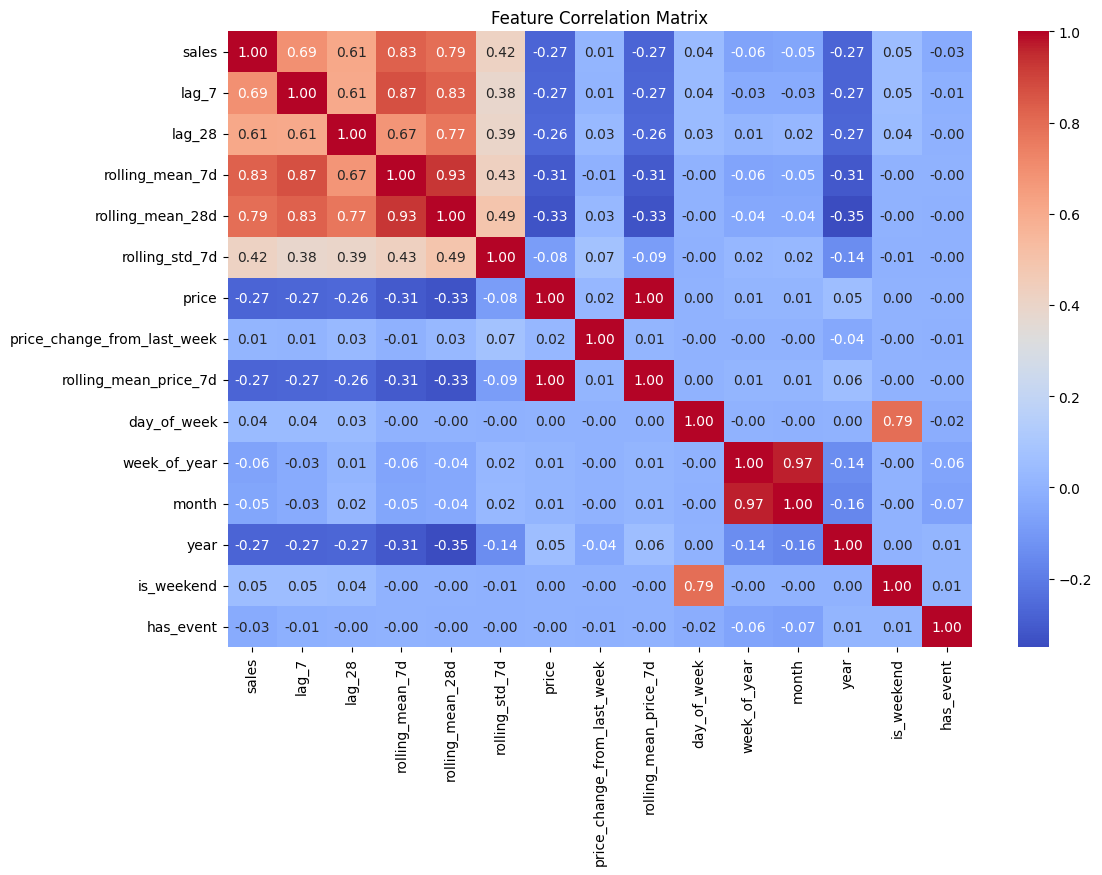

In [ ]:
# Correlation check (numeric features only)
numeric_features = ['sales', 'lag_7','lag_28','rolling_mean_7d','rolling_mean_28d',
                    'rolling_std_7d','price','price_change_from_last_week','rolling_mean_price_7d',
                    'day_of_week','week_of_year','month','year','is_weekend','has_event']

corr_matrix = sales_long[numeric_features].corr()
print("Correlation with target (sales):")
print(corr_matrix['sales'].sort_values(ascending=False))

# visualize correlation

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()


## Holt-Winters Model

In [57]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Dictionary to store forecasts for each item
hw_forecasts = {}
test_sets = {}  # store corresponding test sets

items = sales_long['item_id'].unique()

for item in items:
    # Extract time series for this item
    ts = sales_long[sales_long['item_id'] == item].sort_values('date')
    ts = ts.set_index('date')['sales']

    # Split into train and test
    train = ts[:-28]  # last 28 days as test
    test = ts[-28:]

    # Fit Holt-Winters model
    hw_model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=7).fit()

    # Forecast
    hw_forecast = hw_model.forecast(28)

    # Store forecast
    hw_forecasts[item] = hw_forecast
    test_sets[item] = test


In [58]:
forecast_df = pd.DataFrame(hw_forecasts)
forecast_df.index = test.index  # set test dates as index
forecast_df.T

date,2016-03-28,2016-03-29,2016-03-30,2016-03-31,2016-04-01,2016-04-02,2016-04-03,2016-04-04,2016-04-05,2016-04-06,...,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24
FOODS_2_021,1.995592,2.007691,2.048143,1.978755,2.070635,2.167025,2.065268,1.995592,2.007691,2.048143,...,2.070635,2.167025,2.065268,1.995592,2.007691,2.048143,1.978755,2.070635,2.167025,2.065268
FOODS_2_128,1.567877,1.547533,1.535350,1.540992,1.591444,1.688339,1.611316,1.567877,1.547533,1.535350,...,1.591444,1.688339,1.611316,1.567877,1.547533,1.535350,1.540992,1.591444,1.688339,1.611316
FOODS_2_152,1.476539,1.444162,1.462210,1.429207,1.443073,1.592632,1.608321,1.476539,1.444162,1.462210,...,1.443073,1.592632,1.608321,1.476539,1.444162,1.462210,1.429207,1.443073,1.592632,1.608321
FOODS_2_164,1.444685,1.534255,1.445909,1.443286,1.614428,1.675726,1.490744,1.444685,1.534255,1.445909,...,1.614428,1.675726,1.490744,1.444685,1.534255,1.445909,1.443286,1.614428,1.675726,1.490744
FOODS_2_181,2.058674,2.080557,2.046363,2.066917,2.077129,2.104467,2.111103,2.058674,2.080557,2.046363,...,2.077129,2.104467,2.111103,2.058674,2.080557,2.046363,2.066917,2.077129,2.104467,2.111103
FOODS_2_233,1.308410,1.284617,1.314974,1.301424,1.311695,1.367804,1.304919,1.308410,1.284617,1.314974,...,1.311695,1.367804,1.304919,1.308410,1.284617,1.314974,1.301424,1.311695,1.367804,1.304919
FOODS_2_276,1.348889,1.310761,1.319875,1.296842,1.245087,1.457261,1.642021,1.348889,1.310761,1.319875,...,1.245087,1.457261,1.642021,1.348889,1.310761,1.319875,1.296842,1.245087,1.457261,1.642021
FOODS_2_360,2.744922,2.699772,2.782097,2.692658,2.649403,2.812384,2.750809,2.744922,2.699772,2.782097,...,2.649403,2.812384,2.750809,2.744922,2.699772,2.782097,2.692658,2.649403,2.812384,2.750809
FOODS_2_364,0.511558,0.473689,0.475056,0.483643,0.552248,0.663417,0.553415,0.511558,0.473689,0.475056,...,0.552248,0.663417,0.553415,0.511558,0.473689,0.475056,0.483643,0.552248,0.663417,0.553415
FOODS_2_398,1.857412,1.893125,1.792714,1.899506,2.000829,2.163790,2.034180,1.857412,1.893125,1.792714,...,2.000829,2.163790,2.034180,1.857412,1.893125,1.792714,1.899506,2.000829,2.163790,2.034180


In [59]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Dictionary to store test sets (you already created test_sets during model building)
# test_sets = {}

# List to store evaluation metrics
hw_eval = []

for item in items:
    # Get actual sales from stored test set
    test = test_sets[item]

    # Get forecast
    hw_forecast = hw_forecasts[item]

    # Compute metrics
    mae = mean_absolute_error(test, hw_forecast)
    rmse = np.sqrt(mean_squared_error(test, hw_forecast))
    mape = np.mean(np.abs((test - hw_forecast) / test.replace(0, np.nan))) * 100

    hw_eval.append({
        'item_id': item,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape
    })

# Convert to DataFrame
hw_eval_df = pd.DataFrame(hw_eval)

# Overall average metrics
overall_metrics = hw_eval_df[['MAE', 'RMSE', 'MAPE (%)']].mean()
print("Holt-Winters Overall Metrics:\n", overall_metrics)



Holt-Winters Overall Metrics:
 MAE          0.643081
RMSE         0.758894
MAPE (%)    30.464184
dtype: float64


In [60]:
# Top 10 items with highest MAPE
top_mape_items = hw_eval_df.sort_values('MAPE (%)', ascending=False).head(10)
print("Top 10 items with highest MAPE:\n", top_mape_items)


Top 10 items with highest MAPE:
        item_id       MAE      RMSE   MAPE (%)
8  FOODS_2_364  0.978975  1.062163  62.183379
0  FOODS_2_021  1.122673  1.354783  38.808352
5  FOODS_2_233  0.622185  0.729797  33.389724
6  FOODS_2_276  0.619043  0.700402  31.117088
2  FOODS_2_152  0.333564  0.404596  28.370213
1  FOODS_2_128  0.600688  0.724922  26.767671
3  FOODS_2_164  0.588355  0.741760  24.435454
4  FOODS_2_181  0.588306  0.682762  22.290122
9  FOODS_2_398  0.509283  0.610303  22.198947
7  FOODS_2_360  0.467741  0.577449  15.080888


##SARIMA Model

In [61]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima_forecasts = {}  # to store forecasts for each item
test_sets = {}  # store corresponding test sets

items = sales_long['item_id'].unique()

for item in items:
    # Extract time series for the item
    ts = sales_long[sales_long['item_id'] == item].sort_values('date')
    ts = ts.set_index('date')['sales']

    # Split into train and test
    train = ts[:-28]  # last 28 days as test
    test = ts[-28:]

    # Fit SARIMA model
    sarima_model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7)).fit(disp=False)

    # Forecast
    sarima_forecast = sarima_model.forecast(len(test))

    # Store forecast & test values for evaluation
    sarima_forecasts[item] = sarima_forecast
    test_sets[item] = test


In [62]:
sarima_forecast_df = pd.DataFrame(sarima_forecasts)
sarima_forecast_df.index = test.index
sarima_forecast_df.T


date,2016-03-28,2016-03-29,2016-03-30,2016-03-31,2016-04-01,2016-04-02,2016-04-03,2016-04-04,2016-04-05,2016-04-06,...,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24
FOODS_2_021,1.939721,1.957556,2.019414,1.929952,1.995031,2.091132,1.992913,1.946074,1.945728,1.990530,...,2.008718,2.104240,1.991857,1.945885,1.945927,1.991093,1.933069,2.008698,2.104220,1.991830
FOODS_2_128,1.609728,1.550185,1.505709,1.593909,1.592395,1.657311,1.607498,1.578466,1.552232,1.553369,...,1.590626,1.678575,1.595234,1.577323,1.549622,1.548750,1.550389,1.589394,1.677395,1.593979
FOODS_2_152,1.380506,1.336069,1.324892,1.271865,1.294486,1.433163,1.473982,1.340137,1.309889,1.328251,...,1.295777,1.438926,1.472955,1.337847,1.307411,1.325380,1.259584,1.294374,1.437524,1.471551
FOODS_2_164,1.395935,1.563969,1.481220,1.426185,1.639245,1.709534,1.471380,1.459111,1.550365,1.461714,...,1.626278,1.687288,1.501632,1.455133,1.544521,1.455727,1.452579,1.623484,1.684489,1.498862
FOODS_2_181,2.086766,2.056362,2.056282,2.070929,2.047976,2.122361,2.159592,2.098239,2.085430,2.063238,...,2.100390,2.147139,2.178500,2.128076,2.114728,2.093214,2.128696,2.115280,2.162000,2.193356
FOODS_2_233,1.467002,1.443562,1.423833,1.407600,1.428225,1.488814,1.416368,1.443389,1.447703,1.433107,...,1.447443,1.508015,1.436188,1.463103,1.467400,1.452801,1.437333,1.457290,1.517861,1.446035
FOODS_2_276,1.373791,1.350565,1.355525,1.341402,1.279706,1.489484,1.687149,1.402529,1.354029,1.362336,...,1.267504,1.481639,1.677478,1.392535,1.343877,1.352192,1.322840,1.262398,1.476532,1.672371
FOODS_2_360,2.702217,2.676757,2.762181,2.674238,2.629008,2.792243,2.731941,2.725429,2.680147,2.762306,...,2.628448,2.791072,2.729371,2.723176,2.677984,2.760158,2.670609,2.627377,2.790001,2.728300
FOODS_2_364,0.487872,0.491105,0.503422,0.477627,0.560459,0.671385,0.570113,0.495607,0.491144,0.496594,...,0.543056,0.641637,0.541920,0.476048,0.471703,0.477259,0.471090,0.533410,0.631988,0.532272
FOODS_2_398,1.751216,1.861040,1.756824,1.857257,2.015105,2.161705,2.058372,1.826239,1.888338,1.790362,...,2.007534,2.186365,2.030134,1.825477,1.889772,1.791510,1.881940,2.008824,2.187734,2.031374


## Evaluation Metrics

In [63]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# List to store evaluation metrics
sarima_eval = []

for item in items:
    # Retrieve forecast and corresponding test set
    sarima_forecast = sarima_forecasts[item]
    test = test_sets[item]

    # Compute MAE
    mae = mean_absolute_error(test, sarima_forecast)

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(test, sarima_forecast))

    # Compute MAPE, avoid division by zero
    test_nonzero = test.replace(0, np.nan)
    mape = np.mean(np.abs((test_nonzero - sarima_forecast) / test_nonzero)) * 100

    sarima_eval.append({
        'item_id': item,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape
    })

# Convert to DataFrame
sarima_eval_df = pd.DataFrame(sarima_eval)

# Overall average metrics
overall_metrics = sarima_eval_df[['MAE','RMSE','MAPE (%)']].mean()
print("SARIMA Overall Metrics:\n", overall_metrics)


SARIMA Overall Metrics:
 MAE          0.633174
RMSE         0.745766
MAPE (%)    29.938146
dtype: float64


In [64]:
# Top 10 items with highest MAPE
top_mape_items = sarima_eval_df.sort_values('MAPE (%)', ascending=False).head(10)
print("Top 10 items with highest MAPE:\n", top_mape_items)

Top 10 items with highest MAPE:
        item_id       MAE      RMSE   MAPE (%)
8  FOODS_2_364  0.983085  1.065136  62.545943
0  FOODS_2_021  1.121657  1.329108  39.265183
6  FOODS_2_276  0.595540  0.677984  30.070163
5  FOODS_2_233  0.532910  0.639388  30.061028
2  FOODS_2_152  0.365234  0.424230  27.755254
1  FOODS_2_128  0.596235  0.723562  26.470536
3  FOODS_2_164  0.579938  0.735868  23.944997
9  FOODS_2_398  0.509311  0.611772  22.152338
4  FOODS_2_181  0.569098  0.661673  21.750119
7  FOODS_2_360  0.478732  0.588938  15.365894


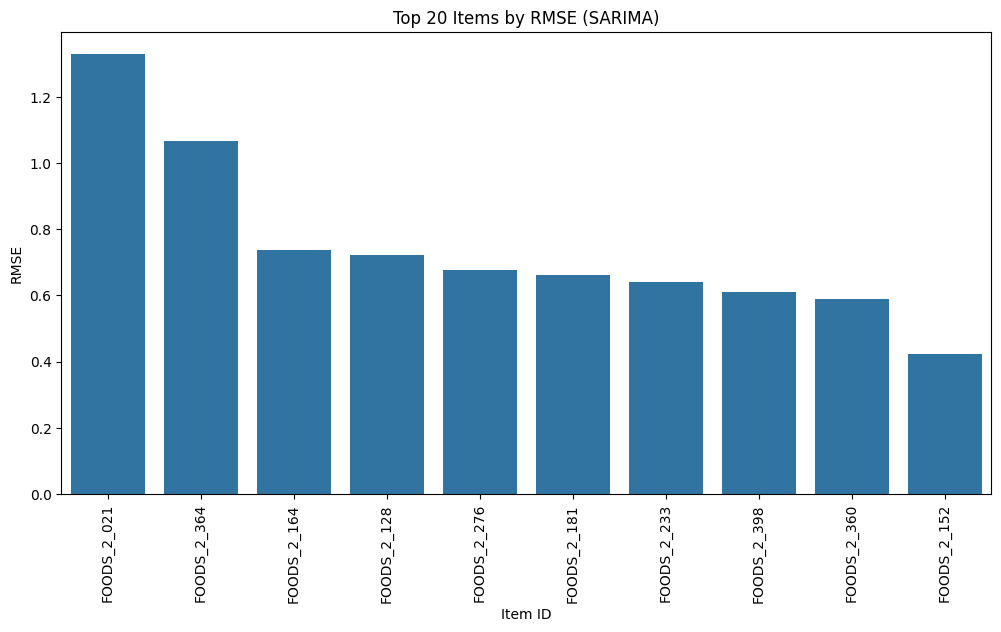

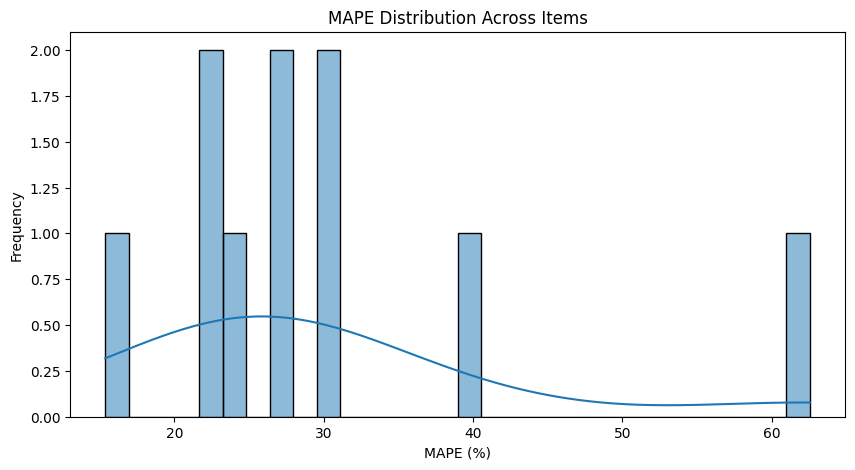

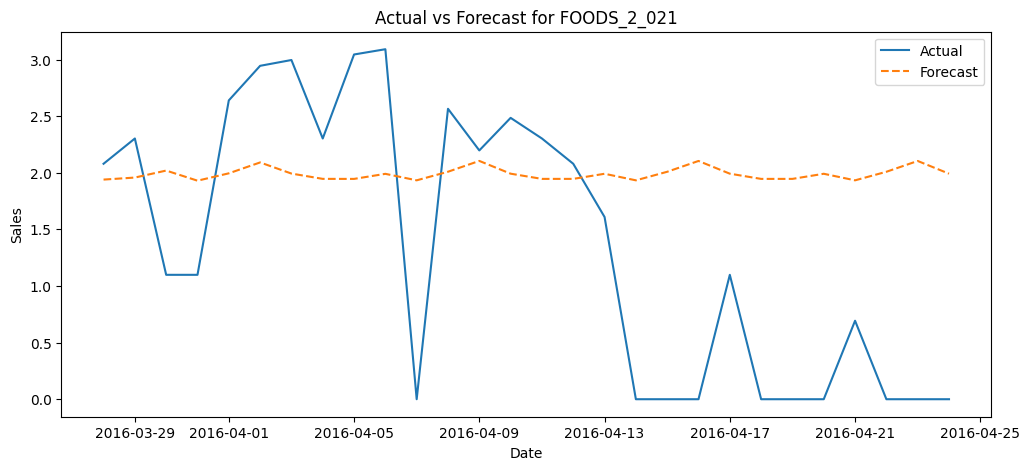

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top 20 items by RMSE for visualization
top_items = sarima_eval_df.sort_values('RMSE', ascending=False).head(20)

plt.figure(figsize=(12,6))
sns.barplot(x='item_id', y='RMSE', data=top_items)
plt.xticks(rotation=90)
plt.title('Top 20 Items by RMSE (SARIMA)')
plt.xlabel('Item ID')
plt.ylabel('RMSE')
plt.show()

# Plot MAPE distribution for all items
plt.figure(figsize=(10,5))
sns.histplot(sarima_eval_df['MAPE (%)'], bins=30, kde=True)
plt.title('MAPE Distribution Across Items')
plt.xlabel('MAPE (%)')
plt.ylabel('Frequency')
plt.show()

# Compare actual vs forecast for a single example item
example_item = items[0]
test = test_sets[example_item]
forecast = sarima_forecasts[example_item]

plt.figure(figsize=(12,5))
plt.plot(test.index, test.values, label='Actual')
plt.plot(test.index, forecast.values, label='Forecast', linestyle='--')
plt.title(f'Actual vs Forecast for {example_item}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


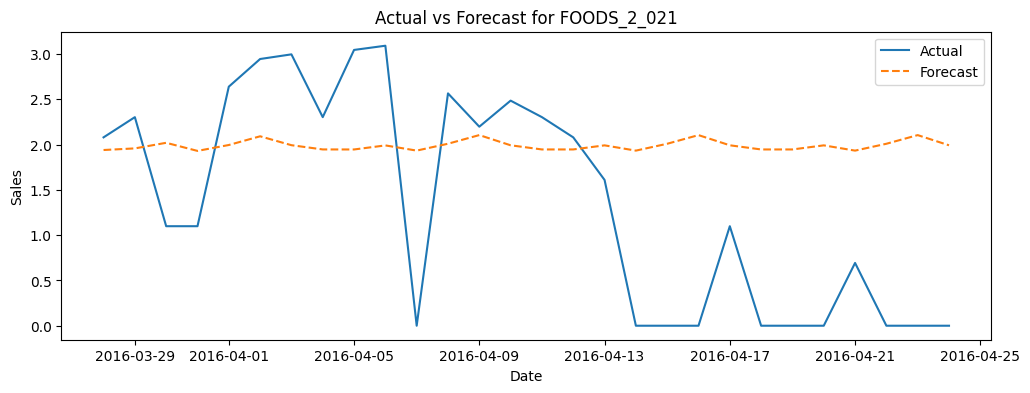

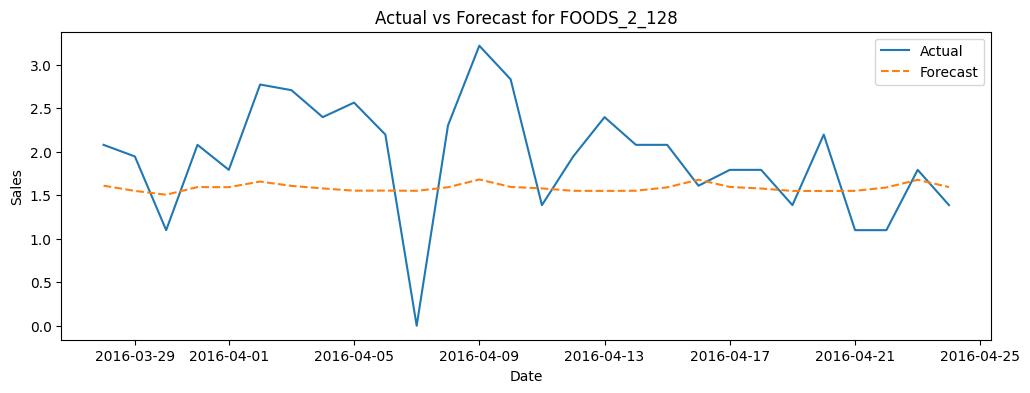

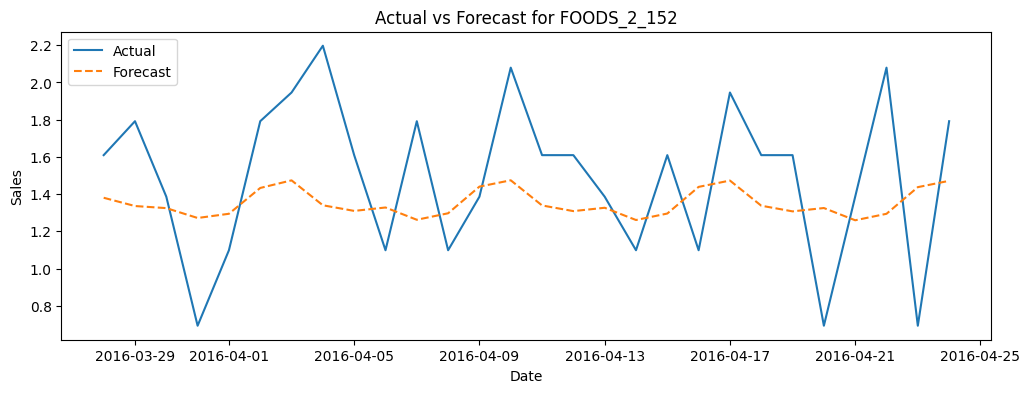

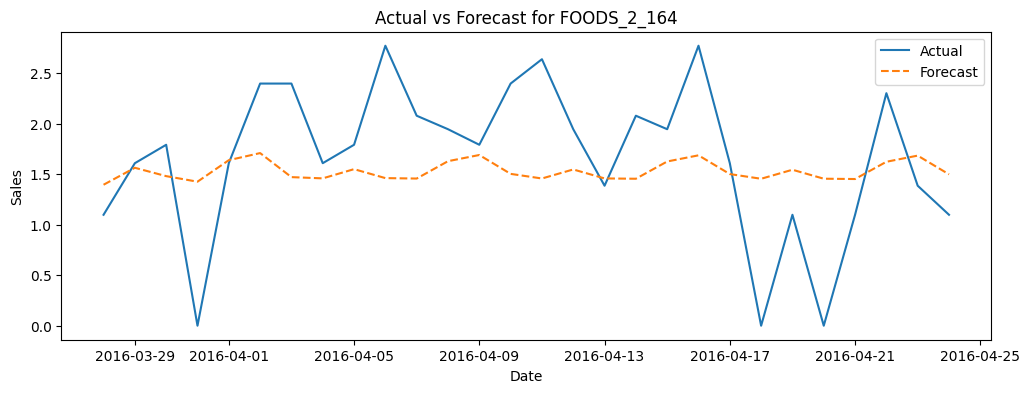

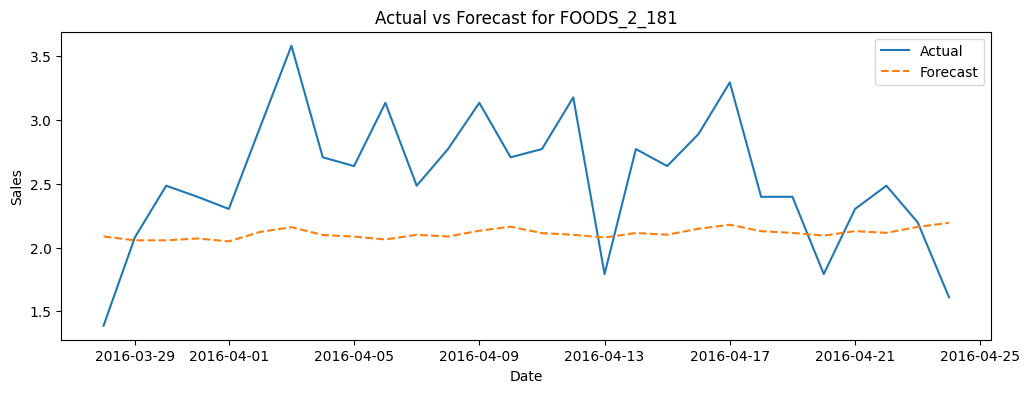

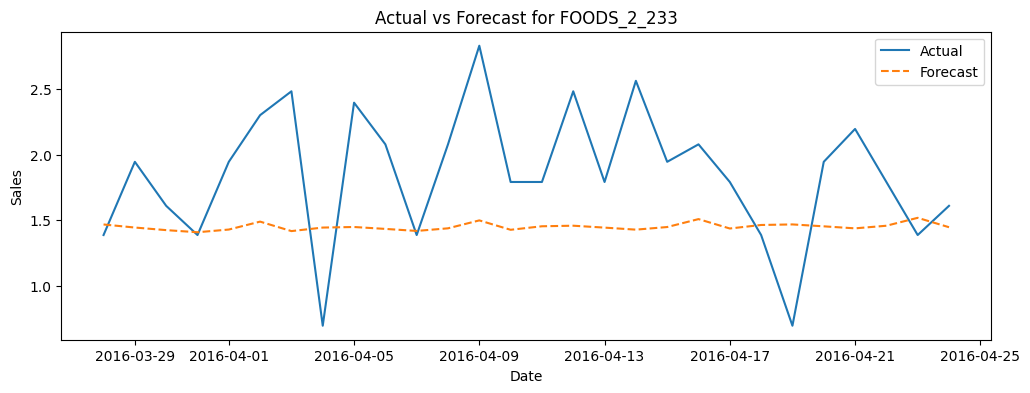

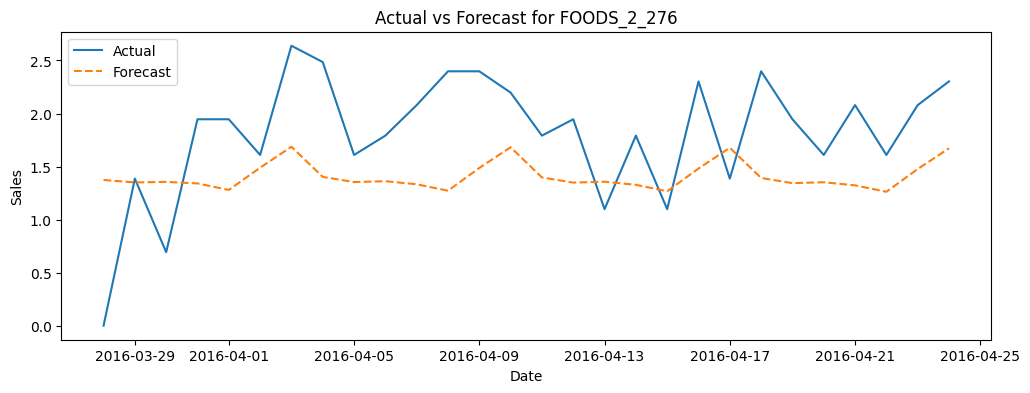

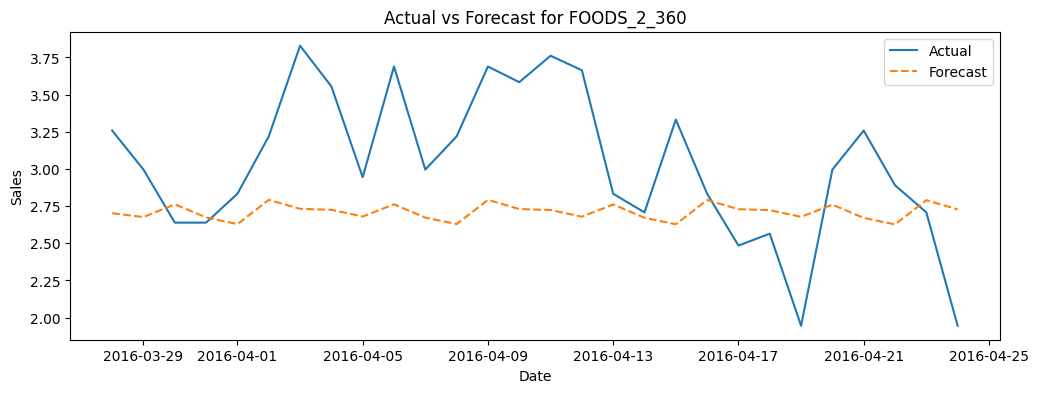

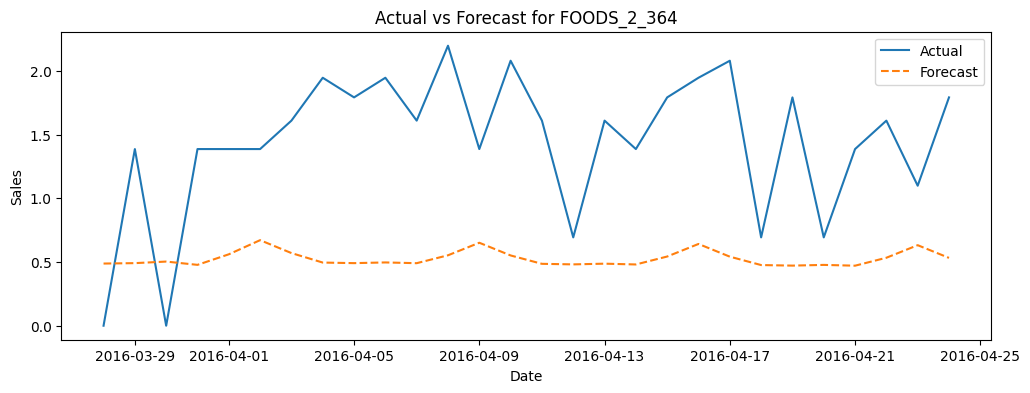

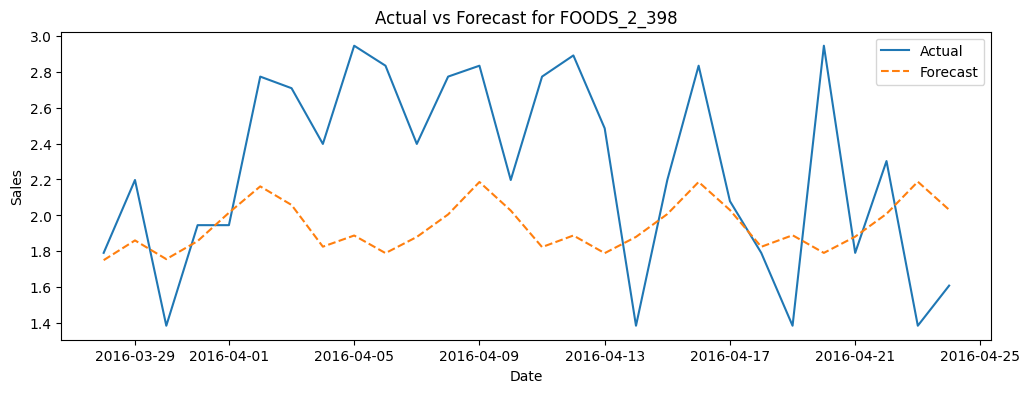

In [66]:
import matplotlib.pyplot as plt

for item in items:
    test = test_sets[item]  # actual sales
    forecast = sarima_forecasts[item]  # SARIMA forecast

    plt.figure(figsize=(12,4))
    plt.plot(test.index, test.values, label='Actual')
    plt.plot(test.index, forecast.values, label='Forecast', linestyle='--')
    plt.title(f'Actual vs Forecast for {item}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()


In [67]:
comparison_df = hw_eval_df.merge(sarima_eval_df, on='item_id', suffixes=('_HW', '_SARIMA'))
comparison_df.head()


,item_id,MAE_HW,RMSE_HW,MAPE (%)_HW,MAE_SARIMA,RMSE_SARIMA,MAPE (%)_SARIMA
0,FOODS_2_021,1.122673,1.354783,38.808352,1.121657,1.329108,39.265183
1,FOODS_2_128,0.600688,0.724922,26.767671,0.596235,0.723562,26.470536
2,FOODS_2_152,0.333564,0.404596,28.370213,0.365234,0.424230,27.755254
3,FOODS_2_164,0.588355,0.741760,24.435454,0.579938,0.735868,23.944997
4,FOODS_2_181,0.588306,0.682762,22.290122,0.569098,0.661673,21.750119


In [68]:
comparison_df['Best_Model_MAE'] = np.where(comparison_df['MAE_HW'] < comparison_df['MAE_SARIMA'], 'HW', 'SARIMA')
comparison_df['Best_Model_RMSE'] = np.where(comparison_df['RMSE_HW'] < comparison_df['RMSE_SARIMA'], 'HW', 'SARIMA')
comparison_df['Best_Model_MAPE'] = np.where(comparison_df['MAPE (%)_HW'] < comparison_df['MAPE (%)_SARIMA'], 'HW', 'SARIMA')


In [69]:
best_mae_count = comparison_df['Best_Model_MAE'].value_counts()
best_rmse_count = comparison_df['Best_Model_RMSE'].value_counts()
best_mape_count = comparison_df['Best_Model_MAPE'].value_counts()

print("Number of items where HW has lower MAE:", best_mae_count.get('HW',0))
print("Number of items where SARIMA has lower MAE:", best_mae_count.get('SARIMA',0))
print("Number of items where HW has lower RMSE:", best_rmse_count.get('HW',0))
print("Number of items where SARIMA has lower RMSE:", best_rmse_count.get('SARIMA',0))
print("Number of items where HW has lower MAPE:", best_mape_count.get('HW',0))
print("Number of items where SARIMA has lower MAPE:", best_mape_count.get('SARIMA',0))


Number of items where HW has lower MAE: 4
Number of items where SARIMA has lower MAE: 6
Number of items where HW has lower RMSE: 4
Number of items where SARIMA has lower RMSE: 6
Number of items where HW has lower MAPE: 3
Number of items where SARIMA has lower MAPE: 7


In [70]:
overall_avg = pd.DataFrame({
    'HW': comparison_df[['MAE_HW', 'RMSE_HW', 'MAPE (%)_HW']].mean(),
    'SARIMA': comparison_df[['MAE_SARIMA', 'RMSE_SARIMA', 'MAPE (%)_SARIMA']].mean()
})
print(overall_avg)


                        HW     SARIMA
MAE_HW            0.643081        NaN
MAE_SARIMA             NaN   0.633174
MAPE (%)_HW      30.464184        NaN
MAPE (%)_SARIMA        NaN  29.938146
RMSE_HW           0.758894        NaN
RMSE_SARIMA            NaN   0.745766


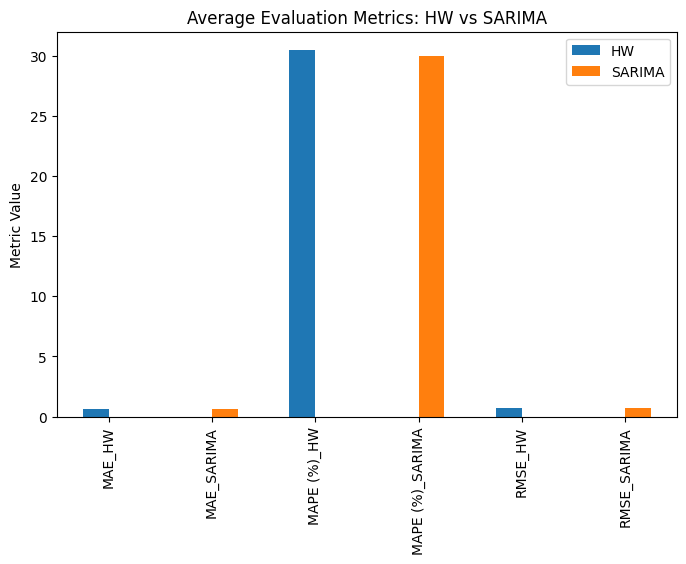

In [71]:
import matplotlib.pyplot as plt

overall_avg.plot(kind='bar', figsize=(8,5))
plt.title('Average Evaluation Metrics: HW vs SARIMA')
plt.ylabel('Metric Value')
plt.show()


###  Feature Scaling for LSTM/GRU

In [72]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Dictionary to store evaluation metrics
lstm_forecasts = {}  # To store forecast for each item
lstm_true = {}       # To store actual values for each item
lstm_eval = []       # To store evaluation metrics

# Get all unique items
items = sales_long['item_id'].unique()

# Loop through each item
for item in items:
    ts = sales_long[sales_long['item_id'] == item].sort_values('date')
    ts_values = ts['sales'].values.reshape(-1, 1)

    # Normalize
    scaler = MinMaxScaler()
    ts_scaled = scaler.fit_transform(ts_values)

    # Train/Validation split
    train_size = int(len(ts_scaled) * 0.8)
    train, val = ts_scaled[:train_size], ts_scaled[train_size:]

    # Create sequences
    def create_sequences(data, window_size=28):
        X, y = [], []
        for i in range(window_size, len(data)):
            X.append(data[i-window_size:i])
            y.append(data[i])
        return np.array(X), np.array(y)

    window_size = 28
    X_train, y_train = create_sequences(train, window_size)
    X_val, y_val = create_sequences(val, window_size)

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=0)

    # Forecast
    y_pred_scaled = model.predict(X_val)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_true = scaler.inverse_transform(y_val)

    # Store predictions and actuals
    lstm_forecasts[item] = y_pred.flatten()
    lstm_true[item] = y_true.flatten()

    # Evaluation metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.nanmean(np.abs((y_true - y_pred) / np.where(y_true==0, np.nan, y_true))) * 100

    # Append results
    lstm_eval.append({
        'item_id': item,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape
    })

# Convert to DataFrame
lstm_eval_df = pd.DataFrame(lstm_eval)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [73]:
# Overall average metrics
overall_metrics = lstm_eval_df[['MAE','RMSE','MAPE (%)']].mean()
print("LSTM Overall Metrics:\n", overall_metrics)



LSTM Overall Metrics:
 MAE          0.435193
RMSE         0.605545
MAPE (%)    29.884428
dtype: float64


In [74]:
# Top 10 items with highest MAPE
top_mape_items = lstm_eval_df.sort_values('MAPE (%)', ascending=False).head(10)
print("Top 10 items with highest MAPE:\n", top_mape_items)

Top 10 items with highest MAPE:
        item_id       MAE      RMSE   MAPE (%)
0  FOODS_2_021  0.423799  0.663754  34.876663
2  FOODS_2_152  0.515396  0.641460  34.705612
1  FOODS_2_128  0.405830  0.618229  34.672265
3  FOODS_2_164  0.587538  0.713941  32.716822
5  FOODS_2_233  0.311712  0.481463  32.487143
6  FOODS_2_276  0.464662  0.604146  30.458350
8  FOODS_2_364  0.452289  0.574862  29.974244
9  FOODS_2_398  0.551500  0.730814  29.032861
7  FOODS_2_360  0.354237  0.554561  21.114517
4  FOODS_2_181  0.284963  0.472223  18.805799


## Evaluation Metrics

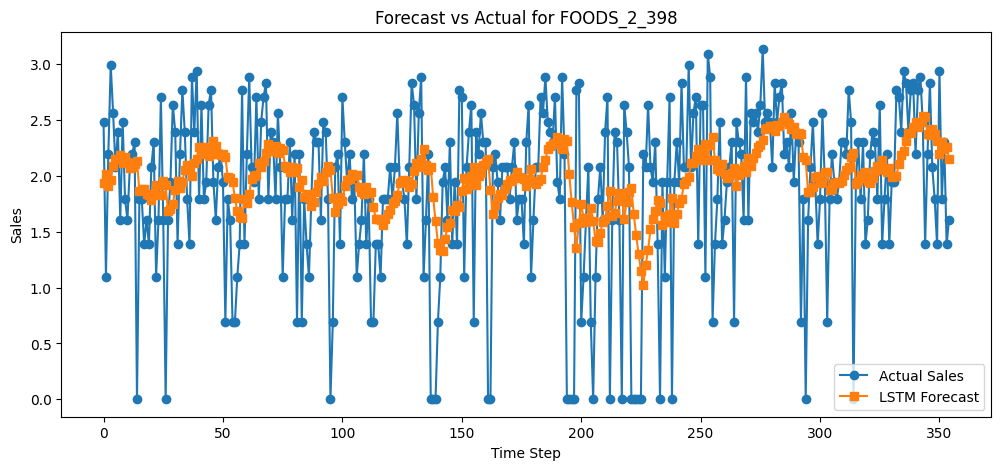

In [75]:
item = 'FOODS_2_398'
y_true = lstm_true[item]      # actual values for this item
y_pred = lstm_forecasts[item] # forecasted values for this item

plt.figure(figsize=(12,5))
plt.plot(y_true, label='Actual Sales', marker='o')
plt.plot(y_pred, label='LSTM Forecast', marker='s')
plt.title(f'Forecast vs Actual for {item}')
plt.xlabel('Time Step')
plt.ylabel('Sales')
plt.legend()
plt.show()


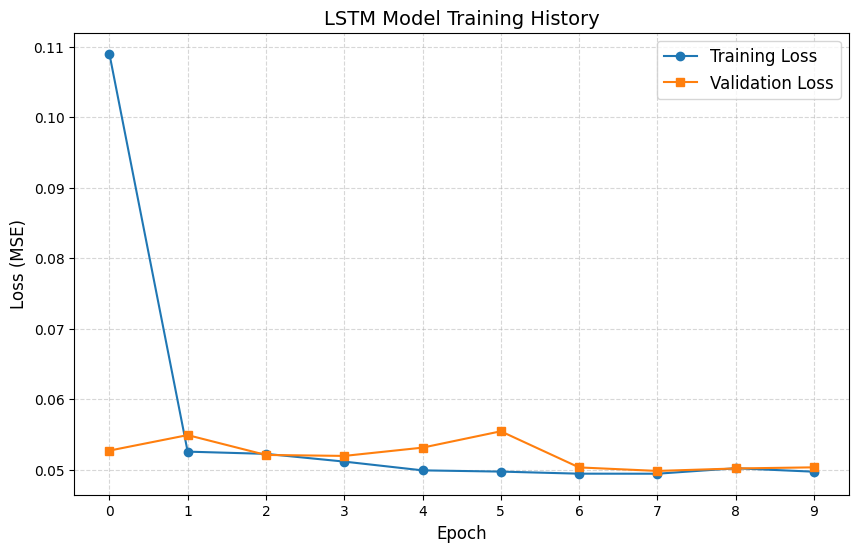

In [76]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], marker='o', label='Training Loss')
plt.plot(history.history['val_loss'], marker='s', label='Validation Loss')
plt.title('LSTM Model Training History', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.xticks(range(0, len(history.history['loss']), 1))
plt.show()


## GRU Model

In [77]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

gru_forecasts = {}  # To store forecasts for each item
gru_true = {}       # To store actual values for each item
gru_eval = []       # To store evaluation metrics

items = sales_long['item_id'].unique()

for item in items:
    ts = sales_long[sales_long['item_id'] == item].sort_values('date')
    ts = ts.set_index('date')['sales']

    # Scale
    ts_values = ts.values.reshape(-1,1)
    scaler = MinMaxScaler()
    ts_scaled = scaler.fit_transform(ts_values)

    # Train-validation split
    train_size = int(len(ts_scaled)*0.8)
    train, val = ts_scaled[:train_size], ts_scaled[train_size:]

    # Sequence creation
    def create_sequences(data, window_size=28):
        X, y = [], []
        for i in range(window_size, len(data)):
            X.append(data[i-window_size:i])
            y.append(data[i])
        return np.array(X), np.array(y)

    X_train, y_train = create_sequences(train)
    X_val, y_val = create_sequences(val)

    # Build GRU model
    model = Sequential()
    model.add(GRU(64, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    history_gru = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=0)

    # Forecast
    y_pred_scaled = model.predict(X_val)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_actual = scaler.inverse_transform(y_val)

    # Store predictions and actuals
    gru_forecasts[item] = y_pred.flatten()
    gru_true[item] = y_actual.flatten()

    # Evaluation
    mae = mean_absolute_error(y_actual, y_pred)
    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    mape = np.mean(np.abs((y_actual - y_pred)/np.where(y_actual==0, np.nan, y_actual)))*100

    gru_eval.append({'item_id': item, 'MAE': mae, 'RMSE': rmse, 'MAPE (%)': mape})

# Convert evaluation to DataFrame
gru_eval_df = pd.DataFrame(gru_eval)
overall_metrics = gru_eval_df[['MAE','RMSE','MAPE (%)']].mean()
print("GRU Overall Metrics:\n", overall_metrics)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
GRU Overall Metrics:
 MAE         0.434431
RMSE        0.604070
MAPE (%)         NaN
dtype: float64


NameError: name 'y_gru' is not defined

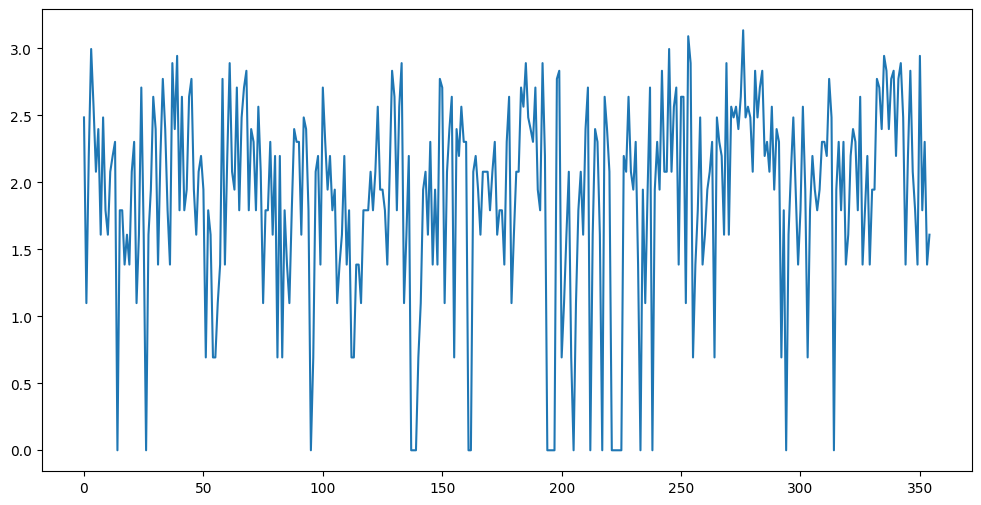

In [78]:
#  Plot Forecast

plt.figure(figsize=(12,6))
plt.plot(y_true, label='Actual')
plt.plot(y_gru, label='GRU Forecast')
plt.title(f'GRU Forecast for {item} in TX_1')
plt.xlabel('Time Step')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
# Plot Training History

plt.figure(figsize=(8,5))
plt.plot(gru_history.history['loss'], label='Train Loss')
plt.plot(gru_history.history['val_loss'], label='Validation Loss')
plt.title('GRU Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


In [ ]:

forecast_gru = y_gru.flatten()

forecast_28_gru = forecast_gru[:28]

# create date index for the next 28 days
future_dates = pd.date_range(start='2025-01-01', periods=28, freq='D')

# build dataframe
df_forecast = pd.DataFrame({
    'date': future_dates,
    'forecast': forecast_28_gru
})

print('Forecast for next 7 days')
df_forecast.head(7)

## Comparison

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming you already have evaluation DataFrames:
# lstm_eval_df, gru_eval_df, sarima_eval_df, hw_eval_df
# Each with columns: ['item_id', 'MAE', 'RMSE', 'MAPE (%)']

# Add a column for model name
lstm_eval_df['Model'] = 'LSTM'
gru_eval_df['Model'] = 'GRU'
sarima_eval_df['Model'] = 'SARIMA'
hw_eval_df['Model'] = 'Holt-Winters'

# Combine all evaluations
combined_eval = pd.concat([lstm_eval_df, gru_eval_df, sarima_eval_df, hw_eval_df], ignore_index=True)

# Compute overall metrics per model
overall_metrics = combined_eval.groupby('Model')[['MAE', 'RMSE', 'MAPE (%)']].mean().reset_index()
print("Overall Metrics by Model:\n", overall_metrics)

# Plot comparison
plt.figure(figsize=(12,5))

# MAE
plt.subplot(1,3,1)
sns.barplot(x='Model', y='MAE', data=overall_metrics)
plt.title('MAE Comparison')
plt.ylabel('MAE')

# RMSE
plt.subplot(1,3,2)
sns.barplot(x='Model', y='RMSE', data=overall_metrics)
plt.title('RMSE Comparison')
plt.ylabel('RMSE')

# MAPE
plt.subplot(1,3,3)
sns.barplot(x='Model', y='MAPE (%)', data=overall_metrics)
plt.title('MAPE (%) Comparison')
plt.ylabel('MAPE (%)')

plt.tight_layout()
plt.show()


In [ ]:
# Rank by RMSE

df_metrics['Rank'] = df_metrics['RMSE'].rank(method='min')
df_metrics = df_metrics.sort_values('Rank')
df_metrics

## Select the best forecast model

In [ ]:
# GRU was best
forecast = y_gru.flatten()
actual = y_true.flatten()
dates = ts.index[-len(forecast):]

## Hyperparameter Tuning

In [ ]:
!pip install optuna

## Bayesian optimization-inspired approach

In [ ]:
import optuna


def create_gru_model(trial):
    model = Sequential()

    # Hyperparameters to tune
    n_layers = trial.suggest_int("n_layers", 1, 3)
    for i in range(n_layers):
        units = trial.suggest_int(f"units_l{i}", 32, 128, step=32)
        return_seq = True if i < n_layers - 1 else False
        model.add(GRU(
            units=units,
            activation='relu',
            return_sequences=return_seq,
            input_shape=(X_train.shape[1], 1) if i == 0 else None
        ))
        dropout = trial.suggest_float(f"dropout_l{i}", 0.1, 0.5, step=0.1)
        model.add(Dropout(dropout))

    model.add(Dense(1))  # regression output

    # Optimizer learning rate
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

def objective(trial):
    model = create_gru_model(trial)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=trial.suggest_categorical("batch_size", [16, 32, 64]),
        verbose=0,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )

    val_loss = min(history.history['val_loss'])  # take the best validation loss
    return val_loss

# Run Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# Print best parameters
print("Best trial:")
trial = study.best_trial
print(trial.params)

In [ ]:
print("Best hyperparameters:")
print(study.best_trial.params)

Best hyperparameters:
{'n_layers': 3, 'units_l0': 64, 'dropout_l0': 0.2, 'units_l1': 96, 'dropout_l1': 0.30000000000000004, 'units_l2': 32, 'dropout_l2': 0.5, 'learning_rate': 0.009612576695163955, 'batch_size': 32}

In [ ]:
best_params = {
    'n_layers': 3,
    'units_l0': 64,
    'dropout_l0': 0.2,
    'units_l1': 96,
    'dropout_l1': 0.3,
    'units_l2': 32,
    'dropout_l2': 0.5,
    'learning_rate': 0.009612576695163955,
    'batch_size': 32
}

# Build GRU model
gru_model = Sequential()

# Layer 0
gru_model.add(GRU(
    units=best_params['units_l0'],
    activation='relu',
    return_sequences=True,
    input_shape=(X_train.shape[1], 1)
))
gru_model.add(Dropout(best_params['dropout_l0']))

# Layer 1
gru_model.add(GRU(
    units=best_params['units_l1'],
    activation='relu',
    return_sequences=True
))
gru_model.add(Dropout(best_params['dropout_l1']))

# Layer 2 (final GRU layer)
gru_model.add(GRU(
    units=best_params['units_l2'],
    activation='relu',
    return_sequences=False
))
gru_model.add(Dropout(best_params['dropout_l2']))

# Output layer
gru_model.add(Dense(1))

# Compile the model
optimizer = Adam(learning_rate=best_params['learning_rate'])
gru_model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae']
)

# Train the model
gru_history = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=best_params['batch_size'],
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )]
)


In [ ]:
# Forecast on Validation
y_gru_scaled = gru_model.predict(X_val)

# Inverse scale predictions
y_gru = scaler.inverse_transform(y_gru_scaled)

# Inverse scale true values
y_true = scaler.inverse_transform(y_val.reshape(-1, 1))

# Flatten for plotting or metrics
y_gru = y_gru.flatten()
y_true = y_true.flatten()


In [ ]:
# To ensure predictions and true values are flat arrays
y_pred = y_gru.reshape(-1)
y_true_flat = y_true.reshape(-1)

# Evaluation metrics
rmse_gru = np.sqrt(mean_squared_error(y_true_flat, y_pred))
mae_gru = mean_absolute_error(y_true_flat, y_pred)

print(f"GRU Forecast - RMSE: {rmse_gru:.2f}, MAE: {mae_gru:.2f}")


In [ ]:
#  Plot Forecast

plt.figure(figsize=(12,6))
plt.plot(y_true, label='Actual', color='blue')
plt.plot(y_gru, label='GRU Forecast', color='orange')
plt.title(f'GRU Forecast vs Actual for {item} in TX_1')
plt.xlabel('Time Step (Days)')
plt.ylabel('Sales Units')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Plot Training History

plt.figure(figsize=(8,5))
plt.plot(gru_history.history['loss'], label='Training Loss', color='blue')
plt.plot(gru_history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('GRU Model Training History', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Flatten forecast
forecast_gru = y_gru.flatten()

# Take next 28 predictions
forecast_28_gru = forecast_gru[:28]  # ensure at least 28 predictions exist

# Create date index for the next 28 days dynamically
last_date = pd.to_datetime(ts.index[-1])
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=28, freq='D')

# Build forecast dataframe
df_forecast = pd.DataFrame({
    'date': future_dates,
    'forecast': forecast_28_gru
})

print('Forecast for next 7 days:')
df_forecast.head(7)

In [ ]:
metrics = {
    'Model': ['Holt-Winters', 'SARIMA', 'LSTM', 'GRU'],
    'RMSE': [hw_rmse, sarima_rmse,  rmse, rmse_gru],
    'MAE': [hw_mae, sarima_mae,  mae, mae_gru],

}

df_metrics = pd.DataFrame(metrics)
df_metrics

In [ ]:
# Rank by RMSE

df_metrics['Rank'] = df_metrics['RMSE'].rank(method='min')
df_metrics = df_metrics.sort_values('Rank')
df_metrics

## Parameters for Inventory Calculations

In [ ]:
# From your dataset
demand = ts.values

# Simulated inventory parameters
on_hand_inventory = int(demand.mean() * 14)      # 2 weeks of demand
safety_stock = int(demand.std() * 1.5)           # demand variability-based
lead_time_days = np.random.randint(5, 15)        # typical retail lead time
holding_cost_rate = 0.05                         # 5% per unit per month

on_hand_inventory, safety_stock, lead_time_days, holding_cost_rate

## Calculate Order Quantity

In [ ]:
# Q = forecast + safety_stock - on_hand_inventory
order_quantity = forecast_28_gru + safety_stock - on_hand_inventory
order_quantity = np.maximum(order_quantity, 0)  # cannot order negative units

In [ ]:
# Calculate Average Inventory for Holding Cost inventory_level = on_hand + orders - sales (simplified)
inventory_level = on_hand_inventory + np.cumsum(order_quantity - actual)
average_inventory = np.mean(inventory_level)

holding_cost = average_inventory * holding_cost_rate


monthly_df = pd.DataFrame(monthly_inv, columns=['date', 'inv'])
holding_cost = monthly_df.groupby(monthly_df['date'].dt.to_period('M'))['inv'].mean().mean()
holding_cost = holding_cost * holding_cost_rate

In [ ]:
# Stockout Rate # Stockout occurs if inventory < 0
stockouts = np.sum(inventory_level < 0)
total_days = len(forecast)
stockout_rate = stockouts / total_days

In [ ]:
# Service Level
service_level = (1 - stockout_rate) * 100

In [ ]:
#  Summary Table

metrics = pd.DataFrame({
    'Metric': ['Average Order Quantity (units)', 'Holding Cost (£/month)', 'Stockout Rate (%)', 'Service Level (%)'],
    'Value': [np.mean(order_quantity), holding_cost, stockout_rate*100, service_level]
})

metrics

## Integration demand forecasting with simulated inventory parameter

In [ ]:
# Simulated inventory parameters

demand = ts.values  # actual historical demand

on_hand_inventory = int(demand.mean() * 14)  # 2 weeks of demand
safety_stock = int(demand.std() * 1.5)       # buffer stock based on variability
lead_time_days = np.random.randint(5, 15)    # typical retail lead time
holding_cost_rate = 0.05                     # £ per unit per month


# Order quantity calculation

# Using GRU forecast + safety stock
order_quantity = forecast_28_gru + safety_stock - on_hand_inventory
order_quantity = np.maximum(order_quantity, 0)  # cannot order negative units

# Daily inventory simulation

# Expand order_quantity to daily resolution if needed
# For simplicity, repeat each weekly order for 7 days


daily_order = np.mean(order_quantity)  # distribute evenly
orders_daily = np.full(len(demand), daily_order)
inventory_level = on_hand_inventory + np.cumsum(orders_daily - demand)


# Calculate KPIs

# Average Order Quantity

avg_order_qty = np.mean(order_quantity)

# Holding Cost (£/month)
monthly_df = pd.DataFrame({
    'date': pd.date_range(start=ts.index[0], periods=len(inventory_level), freq='D'),
    'inv': inventory_level
})
holding_cost = monthly_df.groupby(monthly_df['date'].dt.to_period('M'))['inv'].mean().mean()
holding_cost *= holding_cost_rate

# Stockout Rate (%)
stockout_days = np.sum(inventory_level < 0)
total_days = len(inventory_level)
stockout_rate = 100 * stockout_days / total_days

# Service Level (%)
service_level = 100 - stockout_rate


# Summary Table

metrics = pd.DataFrame({
    'Metric': [
        'Average Order Quantity (units)',
        'Holding Cost (£/month)',
        'Stockout Rate (%)',
        'Service Level (%)'
    ],
    'Value': [
        avg_order_qty,
        round(holding_cost, 2),
        round(stockout_rate, 2),
        round(service_level, 2)
    ]
})

metrics